# Self-Driving Car Engineer Nanodegree


## Project2: ** Advanced Lane Finding** 

** Solution by luk6xff (May 2019)
** Writeup here: [P2 writeup](WRITEUP.md)

### In this project, a goal is to write a software pipeline to identify the lane boundaries in a video.

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [22]:
# Importing some useful packages used in the project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## 1. Camera calibration and distortion coefficients 

Camera intrinsic matrix:
[[  1.15777942e+03   0.00000000e+00   6.67111049e+02]
 [  0.00000000e+00   1.15282305e+03   3.86129069e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Camera distortion coefficients:
[[-0.24688833 -0.02372814 -0.00109843  0.00035105 -0.00259138]]


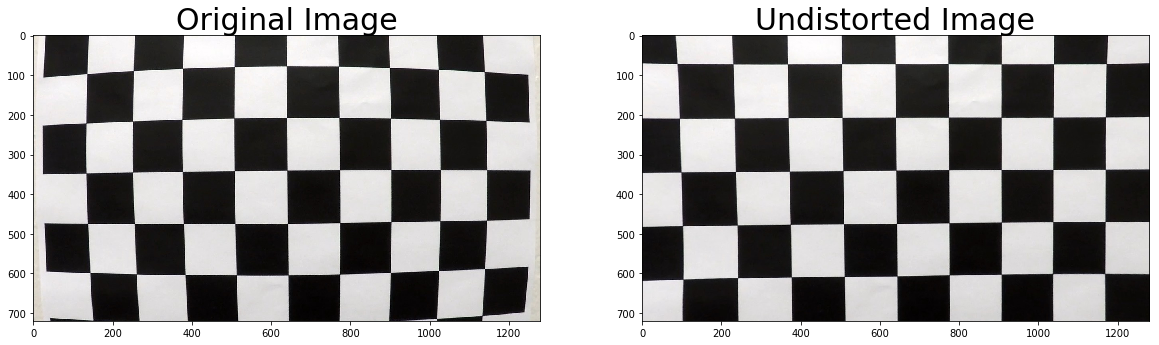

In [34]:
def calibrate_camera(images, nx, ny, img_size):
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    #print(objp[:,:2])
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), cv2.CALIB_CB_ADAPTIVE_THRESH)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            # Save the images
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cols = 8
            #rows = 1
            #plt.figure(figsize=(50,70))
            #plt.subplot(cols, rows, (idx%8)+1)
            #plt.imshow(img)
    # Do camera calibration given object points and image points
    ret, cam_mtx, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return cam_mtx, dist_coeffs



def undistort_image(img, cam_mtx, dist_coeffs):
    return cv2.undistort(img, cam_mtx, dist_coeffs, None, cam_mtx)


############### TESTS ############### 
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Based on used images (camera_cal/calibration*.jpg), I set the number of corners
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Test image
img      = cv2.imread('camera_cal/calibration1.jpg')
img      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])


cam_mtx, dist_coeffs = calibrate_camera(images, nx, ny, img_size)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# cam_mtx     = [fx  0  cx]
#               [0  fy  cy]
#               [0   0   1]
# dist_coeffs = [k1, k2, p1, p2, k3]

######################## CAMERA_PICKLE ########################
# CREATE AND SAVE CAMERA PICKLE FOR LATER USAGE ###########
cam_pickle = {}
cam_pickle["cam_mtx"] = cam_mtx
cam_pickle["dist_coeffs"] = dist_coeffs
print('Camera intrinsic matrix:\n{}'.format(cam_mtx))
print('Camera distortion coefficients:\n{}'.format(dist_coeffs))
pickle.dump(cam_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))
######################## CAMERA_PICKLE ########################

# Undistort image
undistorted_img = undistort_image(img, cam_mtx, dist_coeffs)
###### Debug save
cv2.imwrite('output_images/distorted_image.png', img)
cv2.imwrite('output_images/undistorted_image.png', undistorted_img)

# Print the calibration results - original (distorted) image, and undistorted one.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

## 2. Use color transforms, gradients, etc., to create a thresholded binary image.

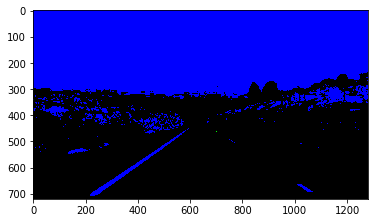

In [35]:
def apply_threshold(img, grad_thresh=(20,100), s_color_thresh=(90,255)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2] #Saturation channel
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find sobel gradient
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobel_x  = np.absolute(sobel_x)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= grad_thresh[0]) & (scaled_sobel <= grad_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_color_thresh[0]) & (s_channel <= s_color_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary))*255
    return color_binary

############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary_img = apply_threshold(undistorted_img, grad_thresh=(150,200), s_color_thresh=(90,255))
###### Debug save
cv2.imwrite('output_images/undistorted_threshlded_image.png', binary_img)
plt.imshow(binary_img)

## 3. Apply a perspective transform to rectify binary image ("birds-eye view" or "top-down- view).

(1280, 720)


True

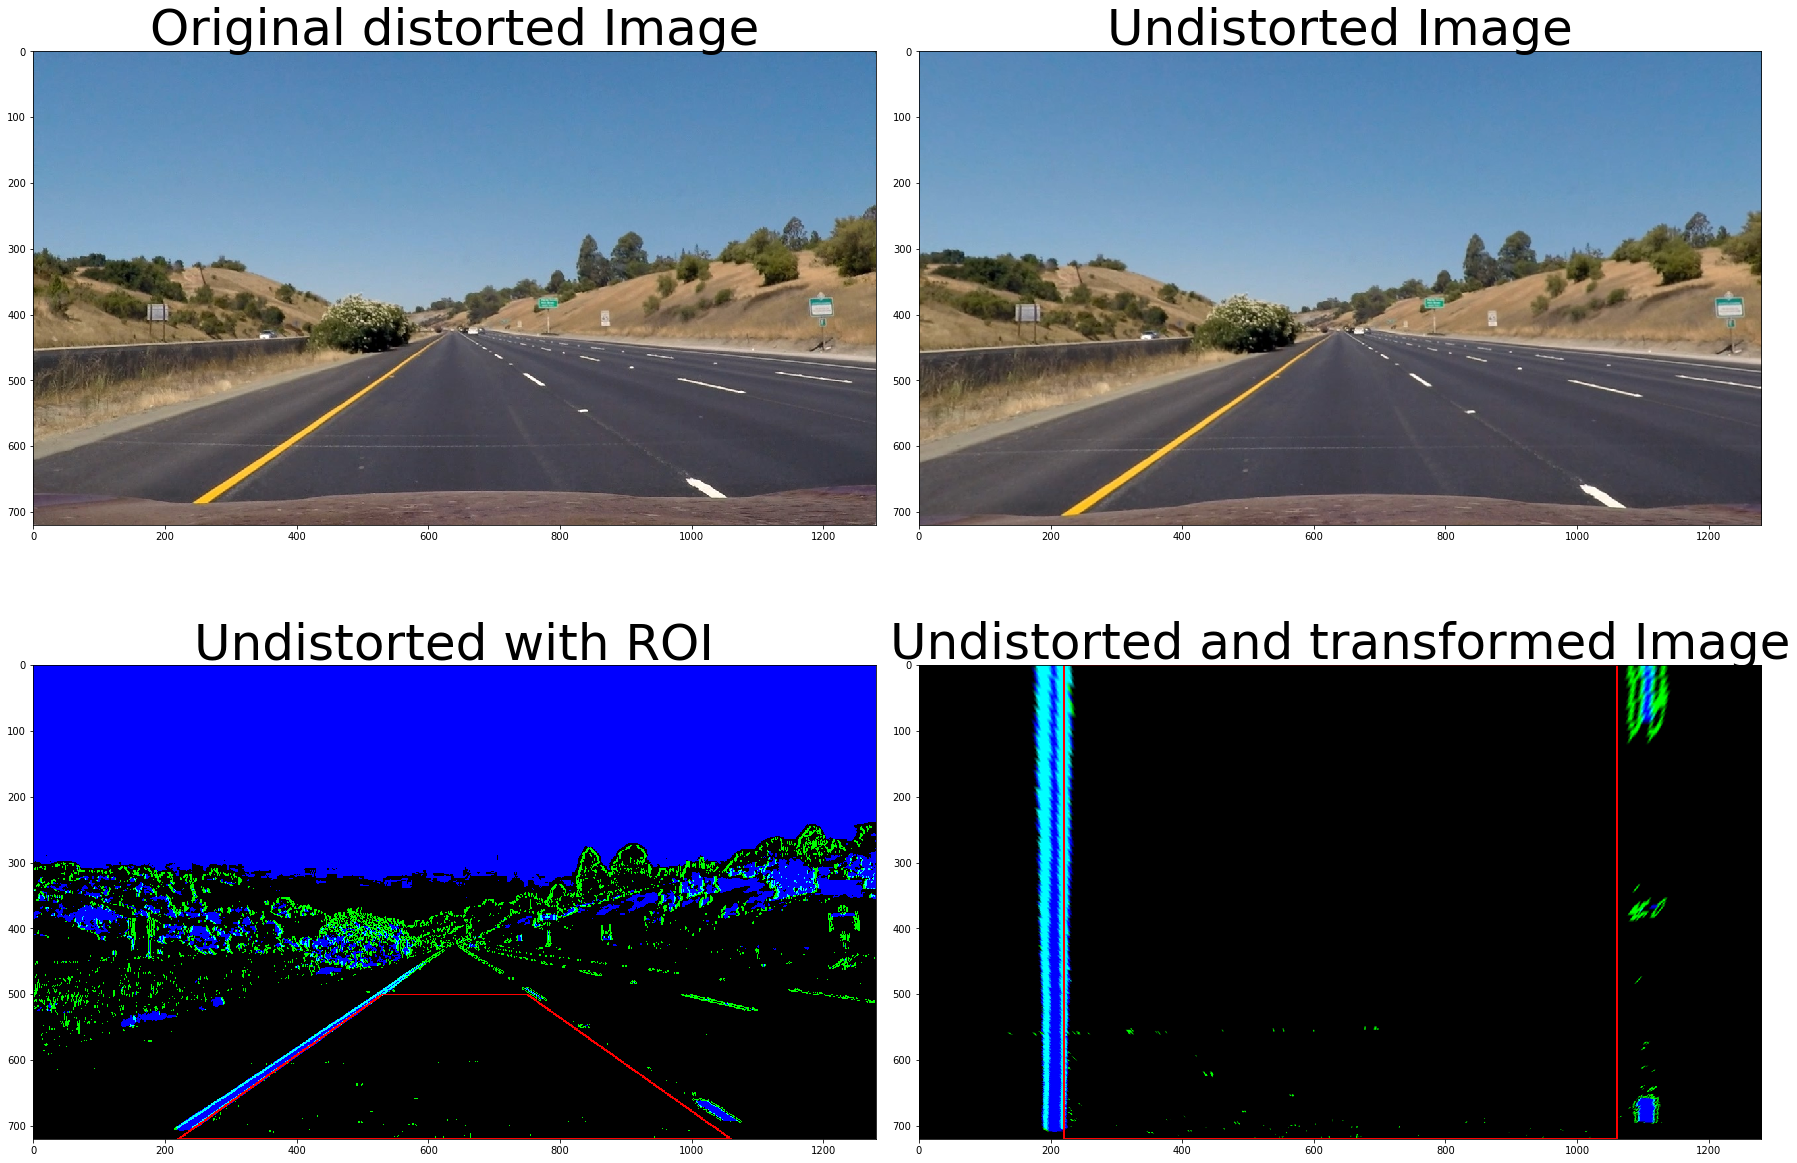

In [38]:
def top_down_view(img):
    img_size = (img.shape[1], img.shape[0])
    print(img_size)
    # 2) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # For source points i pick the points describing trapezoid as shown below
    # 1nd setup: x_center=640, x_offset_top=420, x_offset_bottom=110, y_top=720, y_bottom=500
    x_center=640
    x_offset_top=420
    x_offset_bottom=110
    y_top=img_size[1]#720
    y_bottom=500
    src = np.float32([[x_center+x_offset_bottom,y_bottom],
                      [x_center+x_offset_top,y_top],
                      [x_center-x_offset_top,y_top],
                      [x_center-x_offset_bottom,y_bottom]])
    # 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # For destination points I am taking the image size to map trapezoid on lines (starting from top-left corner)
    # + add small offset to get some offset in the image
    # Values have been chosen after analysing images

    dst = np.float32([[x_center+x_offset_top,0],
                      [x_center+x_offset_top,img_size[1]],
                      [x_center-x_offset_top,img_size[1]],
                      [x_center-x_offset_top,0]])
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Draw src and dst guide lines on both images
    img_with_roi = cv2.polylines(img, np.int32([src]), True, (255,0,0), 2)
    warped = cv2.polylines(warped, np.int32([dst]), True, (255,0,0), 2)
    
    return img_with_roi, warped, Minv


############################## TESTS ##############################
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

######################## CAMERA_PICKLE ########################
# UPDATE CAMERA PICKLE FOR LATER USAGE
cam_pickle = pickle.load(open("camera_cal/camera_calib_pickle.p", "rb") )
cam_pickle["inv_perspective_matrix"] = inv_perspective_matrix
pickle.dump(cam_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))
######################## CAMERA_PICKLE ########################

# Plots
f, (p1, p2) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
p1[0].imshow(image)
p1[0].set_title('Original distorted Image', fontsize=50)
p1[1].imshow(undistorted_img)
p1[1].set_title('Undistorted Image', fontsize=50)
p2[0].imshow(img_with_roi)
p2[0].set_title('Undistorted with ROI', fontsize=50)
p2[1].imshow(transformed_top_down_img)
p2[1].set_title('Undistorted and transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)

###### Debug save
cv2.imwrite('output_images/Undistorted_with_ROI.png', img_with_roi)
cv2.imwrite('output_images/Undistorted_and_transformed_image.png', transformed_top_down_img)

## 4. Detect lane pixels and fit to find the lane boundary.

(1280, 720)


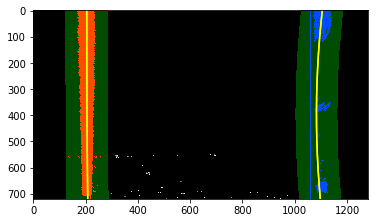

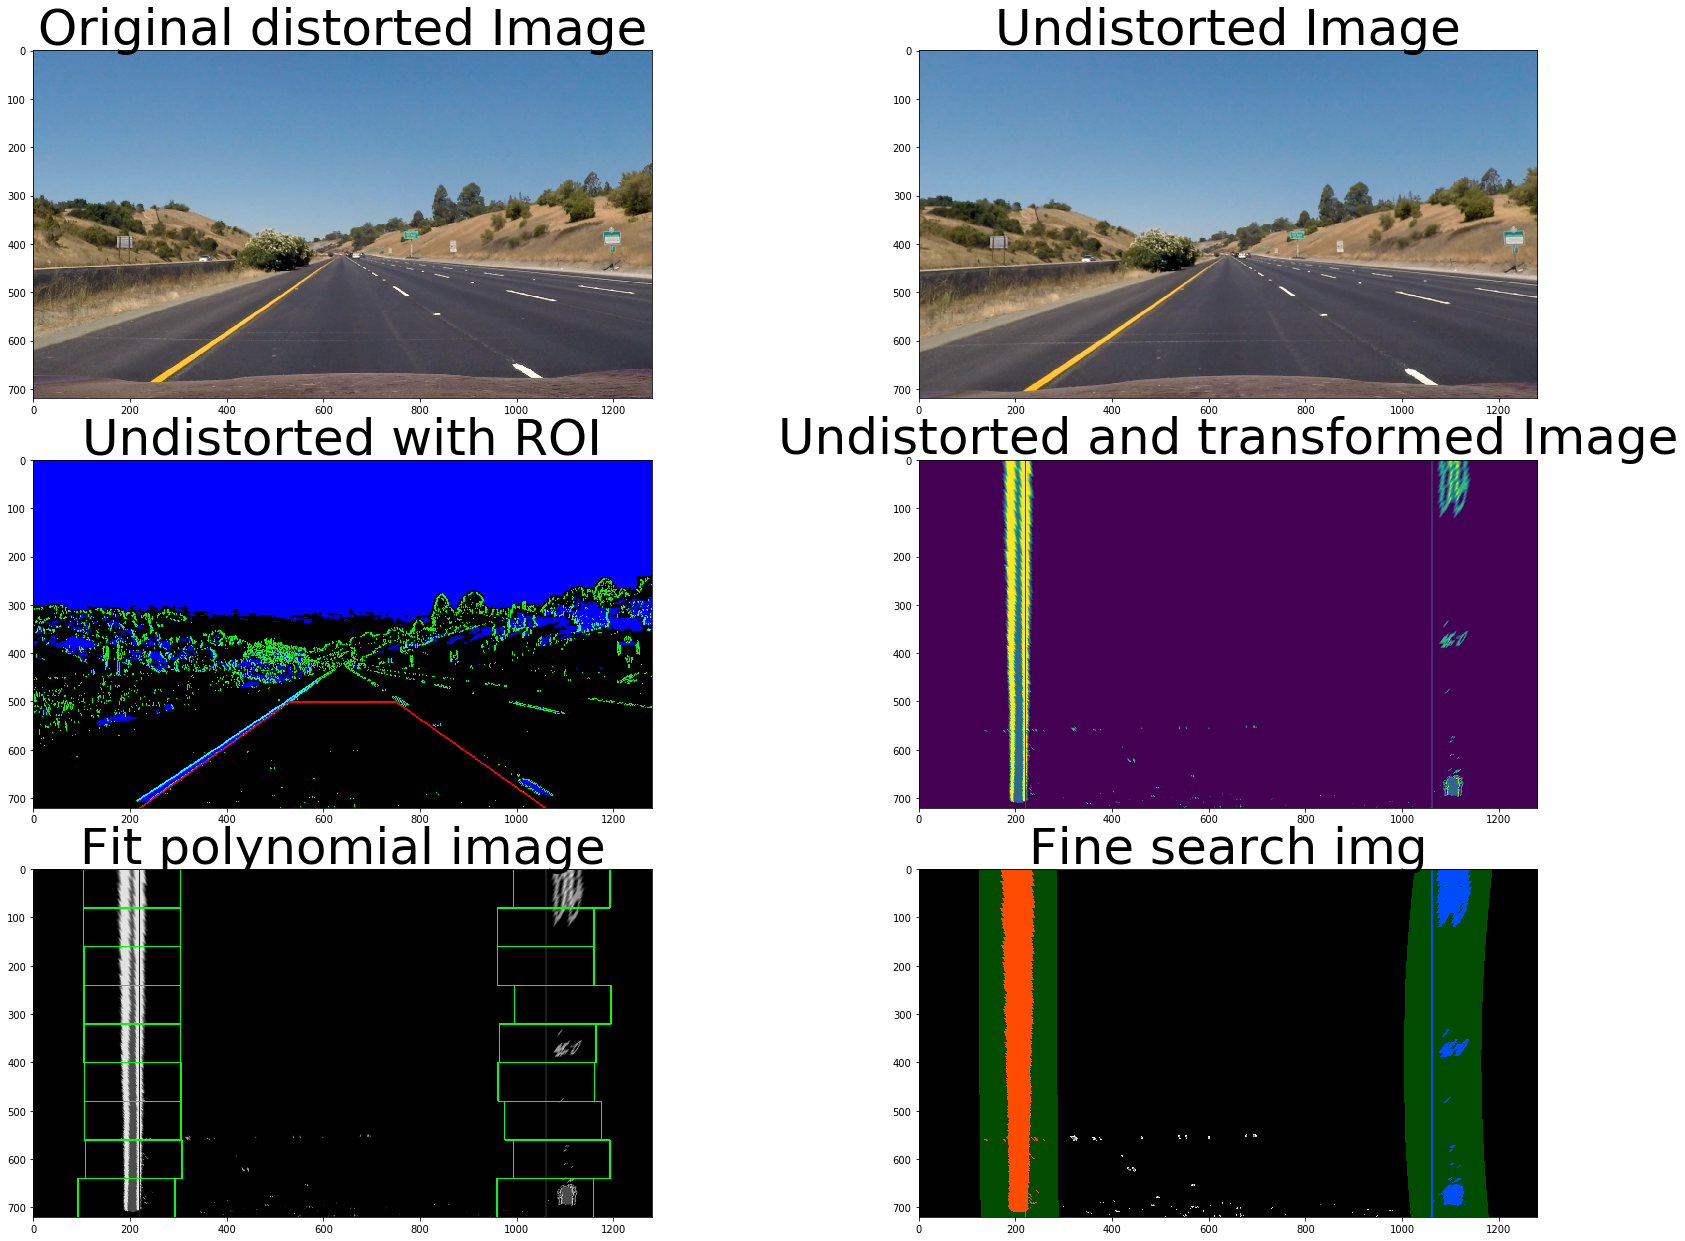

In [26]:
def find_lane_coarse(binary_warped_img):
    '''
    Find the lines with Sliding windows method
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped_img[binary_warped_img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped_img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_img.shape[0] - (window+1)*window_height
        win_y_high = binary_warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img




def fit_polynomial(binary_warped_img, leftx, lefty, rightx, righty):
    """
    Fits a polynomial to all relevant pixels we have found in our sliding windows 
    """
    visualize = True

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization of the polynomial ##
    if visualize:
        # Colors in the left and right lane regions
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        

    return left_fitx, right_fitx, ploty, out_img




def find_lane_fine(binary_warped_img, left_fit, right_fit):
    """
    Set the area to search for activated pixels based on margin
    With a previous set of lane fit parameters in pixel space, search in the neighbourhood 
    and return updated lane pixel vectors
    """
    # The width of the margin around the previous polynomial to search
    margin = 80

    # Grab activated pixels
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ## Visualization ##    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
    window_img = np.zeros_like(out_img)
    
    # Check in case if no pixels were found
    if leftx.size == 0 or rightx.size == 0:
        return False, leftx, lefty, rightx, righty, out_img

    # Fit new polynomials
    left_fitx, right_fitx, ploty, img = fit_polynomial(binary_warped_img, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.imshow(result_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return True, leftx, lefty, rightx, righty, result_img



############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)

# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)

# Plots
f, (p0, p1, p2) = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
p0[0].imshow(image)
p0[0].set_title('Original distorted Image', fontsize=50)
p0[1].imshow(undistorted_img)
p0[1].set_title('Undistorted Image', fontsize=50)
p1[0].imshow(img_with_roi)
p1[0].set_title('Undistorted with ROI', fontsize=50)
p1[1].imshow(binary_top_down)
p1[1].set_title('Undistorted and transformed Image', fontsize=50)
p2[0].imshow(out_img)
p2[0].set_title('Fit polynomial image', fontsize=50)
p2[1].imshow(fine_search_img)
p2[1].set_title('Fine search img', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)



## 5. Determine the curvature of the lane and vehicle position with respect to center.

(1280, 720)
Road curvature radius:  9433.01374756 m.
Vehicle offset from center: -0.0552107946342 m.


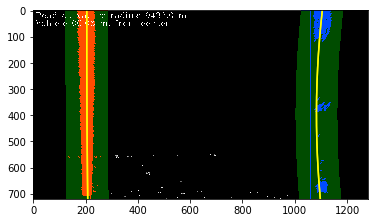

In [27]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
######################## CAMERA_PICKLE ########################
# UPDATE CAMERA PICKLE FOR LATER USAGE
cam_pickle = pickle.load(open("camera_cal/camera_calib_pickle.p", "rb") )
cam_pickle["ym_per_pix"] = ym_per_pix
cam_pickle["xm_per_pix"] = xm_per_pix
pickle.dump(cam_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))
######################## CAMERA_PICKLE ########################


# Return curvature evaluated at yEval given curve fit params
def get_curvature(left_fit, right_fit, y_eval):
    left_radius = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_radius = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return (left_radius + right_radius)/2

# Return vehicle offset from center. > 0 if vehicle is offset to the right of center
def get_offset_from_center(left_fit, right_fit, x_mid, y_eval):
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    x = (left_x + right_x)/2
    return x_mid - x


############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)
binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)

# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)

# Fit a second order polynomial to lane pixels after scaling to real world units (meters)
leftFit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
rightFit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# compute radius of curvature of the road and vehicle position relative to lane
radius = get_curvature(leftFit_m, rightFit_m, binary_top_down.shape[0]*ym_per_pix)
offset = get_offset_from_center(left_fit, right_fit, binary_top_down.shape[1]/2, binary_top_down.shape[0])
print('Road curvature radius: ', radius, 'm.')
print('Vehicle offset from center:', offset*xm_per_pix, 'm.')


# Add measurements to the result image
txt = "Road curvature radius: %05.1f m." % (radius)
cv2.putText(fine_search_img, txt, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 

txt = "Vehicle %05.2f m. from center" % (np.fabs(offset)*xm_per_pix)
cv2.putText(fine_search_img, txt, (10,60), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 
plt.imshow(fine_search_img)

## 6. Warp the detected lane boundaries back onto the original image.

(1280, 720)


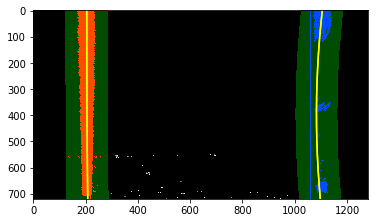

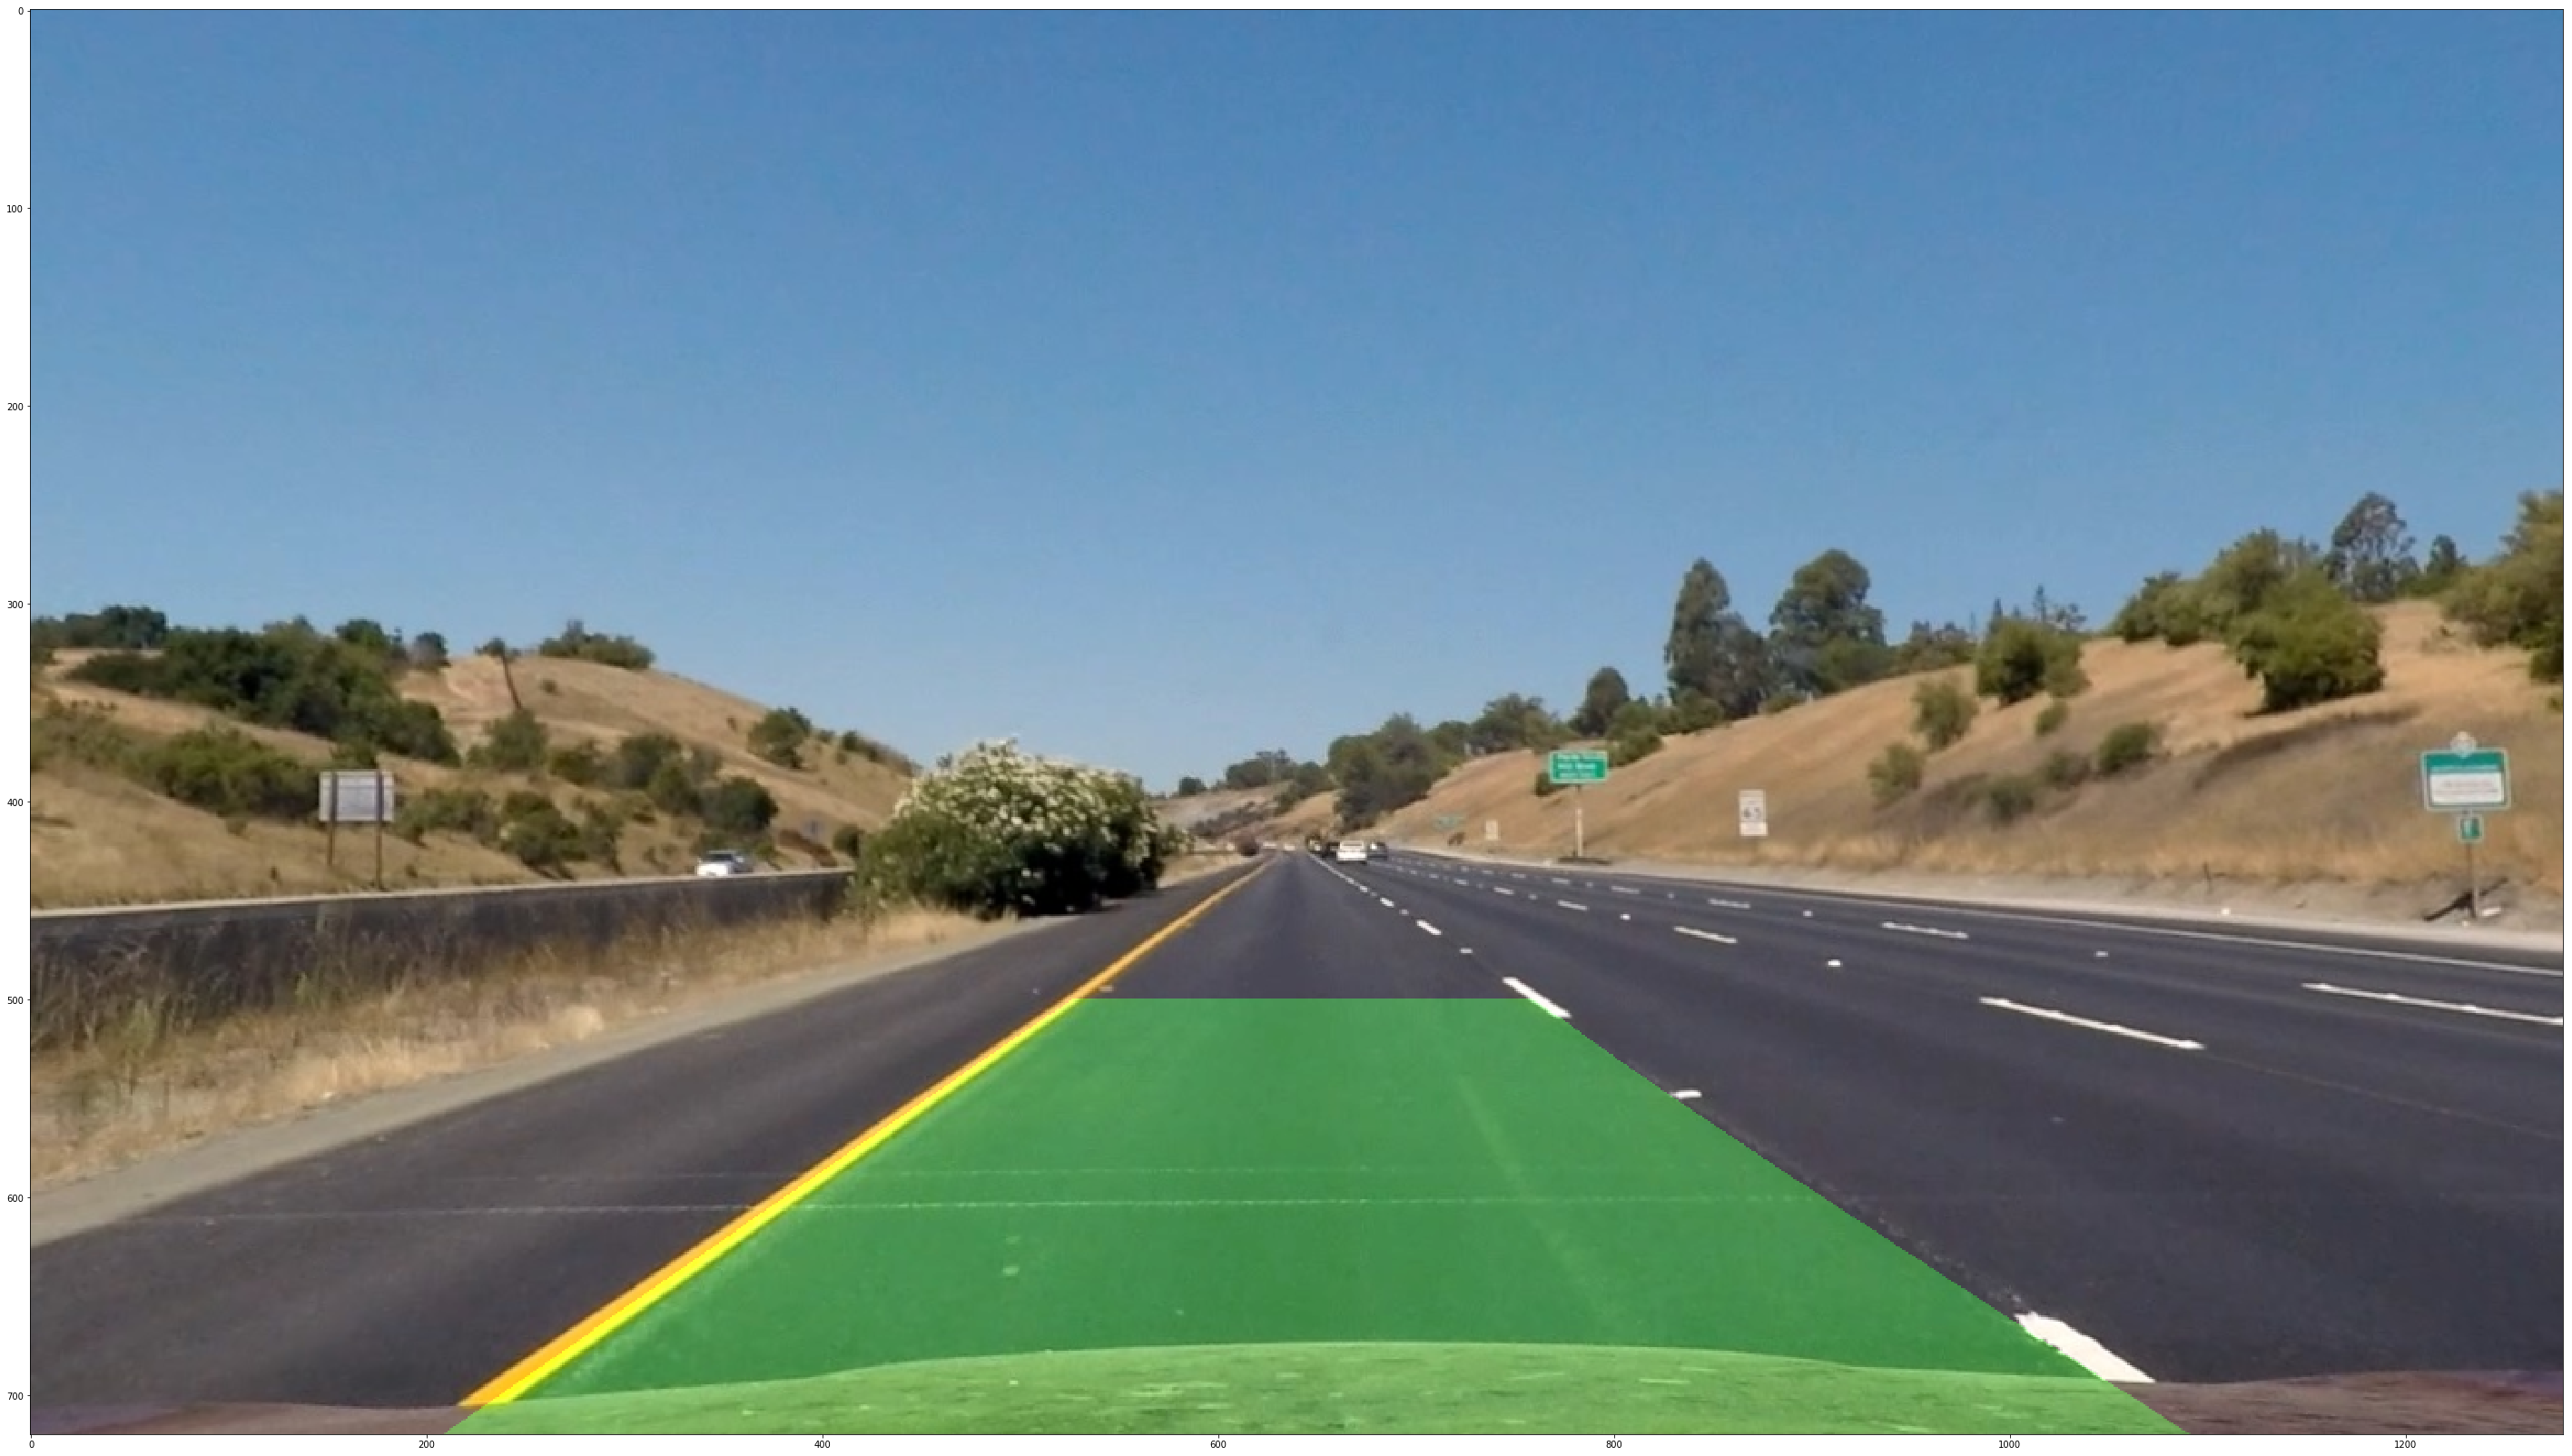

In [28]:
def back_projection(binary_warped_top_view, left_fit, right_fit, inv_perspective_matrix):
    
    # Image
    img_shape = binary_warped_top_view.shape

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_top_view).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (inv_perspective_matrix)
    return cv2.warpPerspective(color_warp, inv_perspective_matrix, (img_shape[1], img_shape[0])) 

    
############### TESTS ###############  
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)
# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)


# Back Projection
result_img = back_projection(binary_top_down, left_fit, right_fit, inv_perspective_matrix)
# Combine the result with the original image
img = cv2.addWeighted(undistorted_img, 1, result_img, 0.3, 0)
plt.figure(figsize=(50,50))
plt.imshow(img)

## 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

(1280, 720)


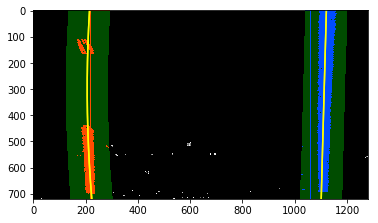

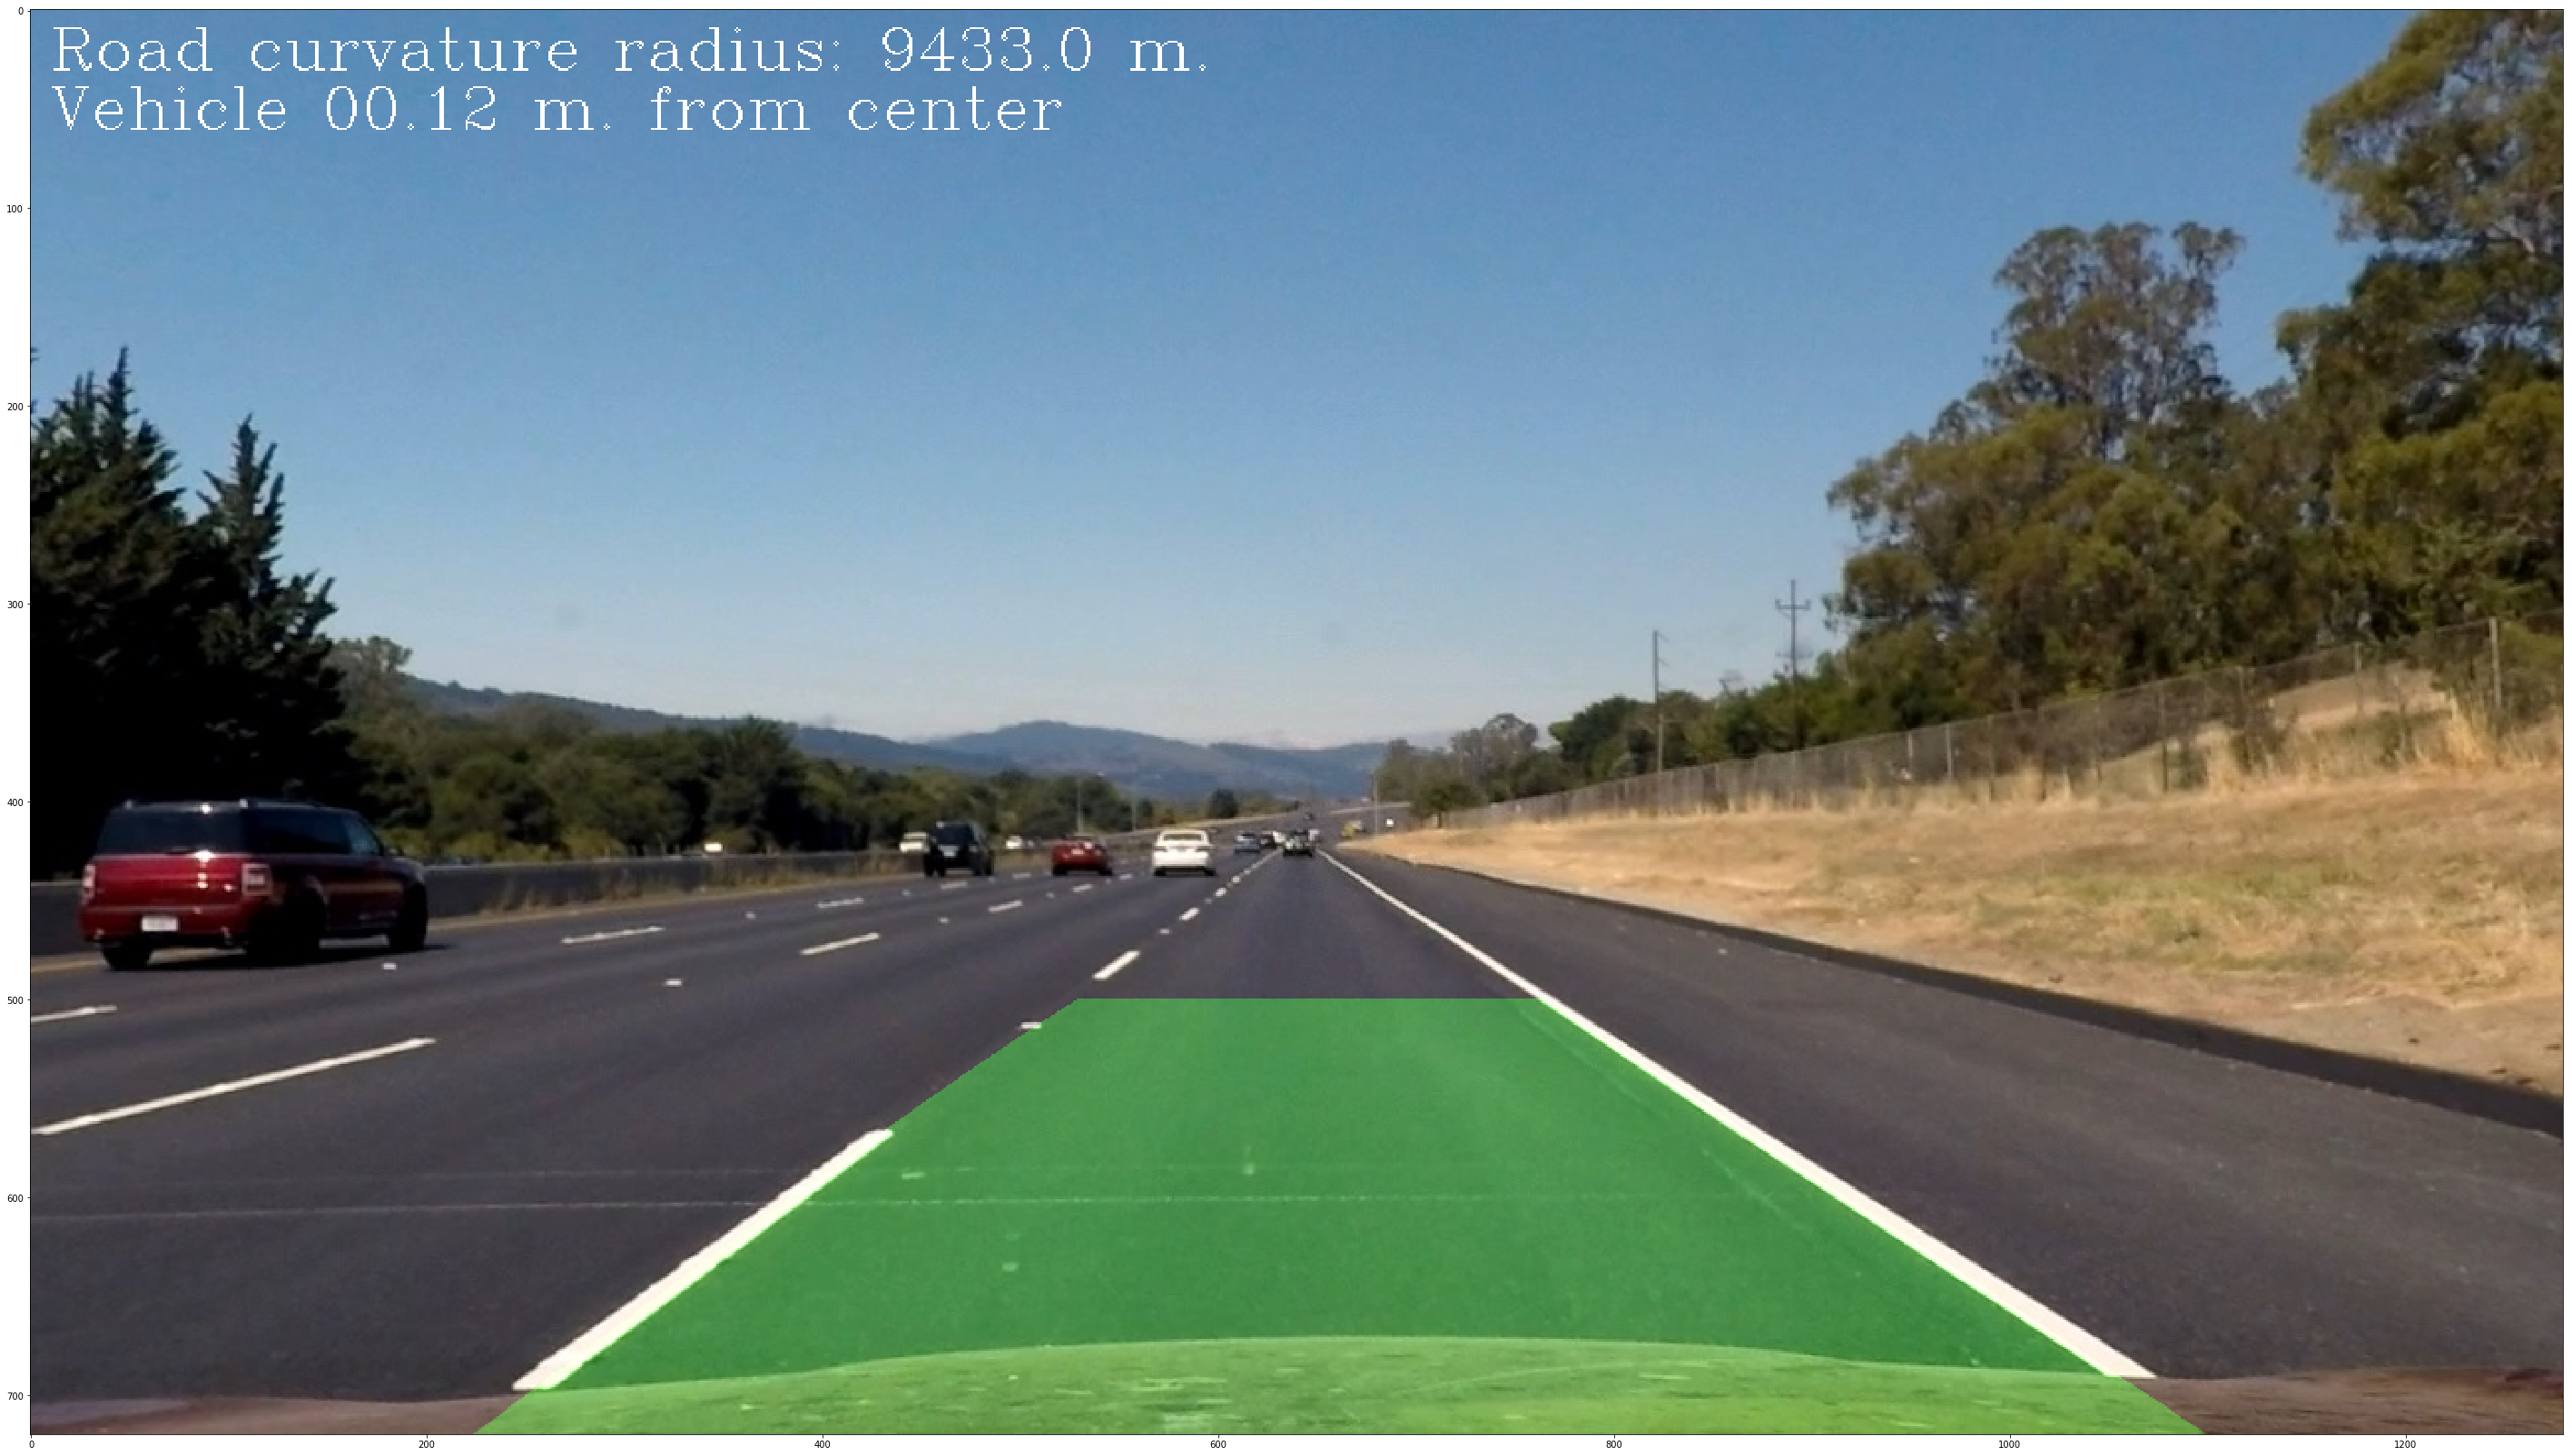

In [29]:
############### TESTS ###############  
image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)
# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)


# Back Projection
result_img = back_projection(binary_top_down, left_fit, right_fit, inv_perspective_matrix)
# Combine the result with the original image
img = cv2.addWeighted(undistorted_img, 1, result_img, 0.3, 0)


# Compute radius of curvature of the road and vehicle position relative to lane
radius = get_curvature(leftFit_m, rightFit_m, binary_top_down.shape[0]*ym_per_pix)
offset = get_offset_from_center(left_fit, right_fit, binary_top_down.shape[1]/2, binary_top_down.shape[0])
# Add measurements to the result image
# Curvature
txt = "Road curvature radius: %05.1f m." % (radius)
cv2.putText(img, txt, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 
# Offset from Center
txt = "Vehicle %05.2f m. from center" % (np.fabs(offset)*xm_per_pix)
cv2.putText(img, txt, (10,60), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1)

plt.figure(figsize=(50,50))
plt.imshow(img)

## 8. Whole Lane detection processing pipeline

In [30]:
class LanesDetector:
    
    def __init__(self):
        self.coarse_search_enabled = True
        self.left_fit = np.array([0, 0, 0])
        self.right_fit = np.array([0, 0, 0])
        self.load_camera_params("camera_cal/camera_calib_pickle.p")

    def load_camera_params(self, params_file_path):
        '''
        Loads gloabl camera parameters athered during cam calibration etc. Search for "CAMERA_PICKLE" tag.
        '''
        cam_pickle = pickle.load(open(params_file_path, "rb") )
        self.cam_mtx = cam_pickle["cam_mtx"]
        self.dist_coeffs = cam_pickle["dist_coeffs"]
        self.inv_perspective_matrix = cam_pickle["inv_perspective_matrix"]
        self.ym_per_pix = cam_pickle["ym_per_pix"] # Meters per pixel in y dimension
        self.xm_per_pix = cam_pickle["xm_per_pix"] # Meters per pixel in x dimension
        #print(cam_pickle)
    
    def process_img(self, image):
        undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
        binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
        img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

        binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
        
        if self.coarse_search_enabled:
            # Search for lane pixels lines first (coarse)
            leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)
            # Fit a second order polynomial to lane pixels
            self.coarse_search_enabled = False
            self.left_fit  = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
        else:
            # Find lane pixels (fine), Here we know where the lanes are on the image
            found_lane, leftx, lefty, rightx, righty, out_img = find_lane_fine(binary_top_down, left_fit, right_fit)
            if found_lane == False:
                self.coarse_search_enabled == True

        if self.coarse_search_enabled == False:
            # Fit a second order polynomial to lane pixels after scaling to real world units (meters)
            leftFit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            rightFit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

            # Back Projection
            result_img = back_projection(binary_top_down, left_fit, right_fit, inv_perspective_matrix)
            # Combine the result with the original image
            img = cv2.addWeighted(undistorted_img, 1, result_img, 0.3, 0)


            # Compute radius of curvature of the road and vehicle position relative to lane
            radius = get_curvature(leftFit_m, rightFit_m, binary_top_down.shape[0]*ym_per_pix)
            offset = get_offset_from_center(left_fit, right_fit, binary_top_down.shape[1]/2, binary_top_down.shape[0])
            # Add measurements to the result image
            # Curvature
            txt = "Road curvature radius: %05.1f m." % (radius)
            cv2.putText(img, txt, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 
            # Offset from Center
            txt = "Vehicle %05.2f m. from center" % (np.fabs(offset)*xm_per_pix)
            cv2.putText(img, txt, (10,60), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1)
        return img
            

lanes_detector = LanesDetector()       

## 9. Search for lanes in Project Video stream 

(1280, 720)
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(1280, 720)


  0%|          | 1/1261 [00:00<03:57,  5.30it/s]

(1280, 720)


  0%|          | 3/1261 [00:00<03:12,  6.53it/s]

(1280, 720)


  0%|          | 4/1261 [00:00<02:55,  7.18it/s]

(1280, 720)


  0%|          | 5/1261 [00:00<02:49,  7.39it/s]

(1280, 720)
(1280, 720)


  1%|          | 7/1261 [00:00<02:34,  8.14it/s]

(1280, 720)
(1280, 720)


  1%|          | 10/1261 [00:01<04:40,  4.46it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  1%|          | 13/1261 [00:02<03:11,  6.53it/s]

(1280, 720)
(1280, 720)


  1%|          | 15/1261 [00:02<02:45,  7.53it/s]

(1280, 720)
(1280, 720)


  1%|▏         | 17/1261 [00:02<02:26,  8.51it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 19/1261 [00:02<02:16,  9.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  2%|▏         | 21/1261 [00:02<02:10,  9.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  2%|▏         | 25/1261 [00:03<02:15,  9.14it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 27/1261 [00:03<02:08,  9.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  2%|▏         | 30/1261 [00:03<02:20,  8.79it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 32/1261 [00:04<02:18,  8.85it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 34/1261 [00:04<02:20,  8.73it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 35/1261 [00:04<02:22,  8.60it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 37/1261 [00:04<02:22,  8.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  3%|▎         | 41/1261 [00:05<02:11,  9.27it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 43/1261 [00:05<02:20,  8.69it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 44/1261 [00:05<02:19,  8.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 48/1261 [00:05<02:06,  9.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 50/1261 [00:05<02:02,  9.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 54/1261 [00:06<01:56, 10.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 56/1261 [00:06<02:04,  9.64it/s]

(1280, 720)
(1280, 720)


  5%|▍         | 58/1261 [00:06<02:08,  9.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▍         | 62/1261 [00:07<02:01,  9.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▌         | 65/1261 [00:07<01:59, 10.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▌         | 67/1261 [00:07<01:59, 10.02it/s]

(1280, 720)
(1280, 720)


  5%|▌         | 69/1261 [00:07<01:59,  9.98it/s]

(1280, 720)
(1280, 720)


  6%|▌         | 72/1261 [00:08<02:02,  9.70it/s]

(1280, 720)
(1280, 720)


  6%|▌         | 73/1261 [00:08<02:04,  9.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  6%|▌         | 76/1261 [00:08<02:01,  9.76it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  6%|▋         | 79/1261 [00:08<02:03,  9.56it/s]

(1280, 720)
(1280, 720)


  6%|▋         | 81/1261 [00:09<02:16,  8.62it/s]

(1280, 720)
(1280, 720)


  7%|▋         | 84/1261 [00:09<02:20,  8.36it/s]

(1280, 720)
(1280, 720)


  7%|▋         | 86/1261 [00:09<02:18,  8.49it/s]

(1280, 720)
(1280, 720)


  7%|▋         | 88/1261 [00:10<02:15,  8.67it/s]

(1280, 720)
(1280, 720)


  7%|▋         | 90/1261 [00:10<02:10,  8.94it/s]

(1280, 720)
(1280, 720)


  7%|▋         | 92/1261 [00:10<02:06,  9.24it/s]

(1280, 720)
(1280, 720)


  7%|▋         | 94/1261 [00:10<02:02,  9.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 97/1261 [00:10<02:04,  9.35it/s]

(1280, 720)
(1280, 720)


  8%|▊         | 98/1261 [00:11<02:03,  9.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 102/1261 [00:11<02:01,  9.53it/s]

(1280, 720)
(1280, 720)


  8%|▊         | 104/1261 [00:11<02:00,  9.58it/s]

(1280, 720)
(1280, 720)


  8%|▊         | 106/1261 [00:11<02:01,  9.49it/s]

(1280, 720)
(1280, 720)


  9%|▊         | 108/1261 [00:12<01:58,  9.72it/s]

(1280, 720)
(1280, 720)


  9%|▊         | 110/1261 [00:12<02:05,  9.19it/s]

(1280, 720)
(1280, 720)


  9%|▉         | 112/1261 [00:12<02:13,  8.58it/s]

(1280, 720)
(1280, 720)


  9%|▉         | 114/1261 [00:12<02:08,  8.93it/s]

(1280, 720)
(1280, 720)


  9%|▉         | 116/1261 [00:13<02:10,  8.77it/s]

(1280, 720)
(1280, 720)


  9%|▉         | 117/1261 [00:13<02:08,  8.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 10%|▉         | 121/1261 [00:13<01:58,  9.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 10%|▉         | 124/1261 [00:13<01:56,  9.78it/s]

(1280, 720)
(1280, 720)


 10%|▉         | 125/1261 [00:13<02:02,  9.28it/s]

(1280, 720)
(1280, 720)


 10%|█         | 128/1261 [00:14<01:56,  9.72it/s]

(1280, 720)
(1280, 720)


 10%|█         | 129/1261 [00:14<01:57,  9.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█         | 133/1261 [00:14<01:52, 10.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█         | 135/1261 [00:14<01:51, 10.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█         | 139/1261 [00:15<01:52,  9.98it/s]

(1280, 720)
(1280, 720)


 11%|█         | 141/1261 [00:15<01:58,  9.44it/s]

(1280, 720)
(1280, 720)


 11%|█▏        | 142/1261 [00:15<01:56,  9.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█▏        | 145/1261 [00:15<01:56,  9.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 149/1261 [00:16<01:50, 10.02it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 151/1261 [00:16<01:50, 10.02it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 155/1261 [00:16<01:47, 10.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 157/1261 [00:17<01:47, 10.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 161/1261 [00:17<01:49, 10.02it/s]

(1280, 720)
(1280, 720)


 13%|█▎        | 163/1261 [00:17<01:50,  9.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 165/1261 [00:18<04:23,  4.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 169/1261 [00:18<03:02,  6.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▎        | 172/1261 [00:19<02:25,  7.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▍        | 175/1261 [00:19<02:04,  8.76it/s]

(1280, 720)
(1280, 720)


 14%|█▍        | 177/1261 [00:19<01:57,  9.24it/s]

(1280, 720)
(1280, 720)


 14%|█▍        | 179/1261 [00:19<01:54,  9.48it/s]

(1280, 720)
(1280, 720)


 14%|█▍        | 181/1261 [00:20<01:51,  9.69it/s]

(1280, 720)
(1280, 720)


 15%|█▍        | 183/1261 [00:20<01:50,  9.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▍        | 186/1261 [00:20<01:52,  9.54it/s]

(1280, 720)
(1280, 720)


 15%|█▍        | 188/1261 [00:20<01:50,  9.70it/s]

(1280, 720)
(1280, 720)


 15%|█▍        | 189/1261 [00:21<01:52,  9.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▌        | 193/1261 [00:21<01:48,  9.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▌        | 195/1261 [00:21<01:48,  9.85it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 199/1261 [00:22<01:50,  9.63it/s]

(1280, 720)
(1280, 720)


 16%|█▌        | 200/1261 [00:22<01:52,  9.45it/s]

(1280, 720)
(1280, 720)


 16%|█▌        | 203/1261 [00:22<01:59,  8.84it/s]

(1280, 720)
(1280, 720)


 16%|█▋        | 205/1261 [00:22<01:55,  9.16it/s]

(1280, 720)
(1280, 720)


 16%|█▋        | 207/1261 [00:22<01:53,  9.32it/s]

(1280, 720)
(1280, 720)


 17%|█▋        | 209/1261 [00:23<01:54,  9.20it/s]

(1280, 720)
(1280, 720)


 17%|█▋        | 211/1261 [00:23<01:51,  9.38it/s]

(1280, 720)
(1280, 720)


 17%|█▋        | 213/1261 [00:23<01:51,  9.44it/s]

(1280, 720)
(1280, 720)


 17%|█▋        | 214/1261 [00:23<01:53,  9.23it/s]

(1280, 720)
(1280, 720)


 17%|█▋        | 217/1261 [00:23<01:50,  9.45it/s]

(1280, 720)
(1280, 720)


 17%|█▋        | 219/1261 [00:24<01:48,  9.63it/s]

(1280, 720)
(1280, 720)


 18%|█▊        | 221/1261 [00:24<01:47,  9.69it/s]

(1280, 720)
(1280, 720)


 18%|█▊        | 223/1261 [00:24<01:47,  9.65it/s]

(1280, 720)
(1280, 720)


 18%|█▊        | 225/1261 [00:24<01:47,  9.60it/s]

(1280, 720)
(1280, 720)


 18%|█▊        | 226/1261 [00:24<01:47,  9.62it/s]

(1280, 720)
(1280, 720)


 18%|█▊        | 229/1261 [00:25<01:47,  9.62it/s]

(1280, 720)
(1280, 720)


 18%|█▊        | 230/1261 [00:25<01:46,  9.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▊        | 234/1261 [00:25<01:47,  9.59it/s]

(1280, 720)
(1280, 720)


 19%|█▊        | 236/1261 [00:25<01:46,  9.66it/s]

(1280, 720)
(1280, 720)


 19%|█▉        | 238/1261 [00:26<01:47,  9.50it/s]

(1280, 720)
(1280, 720)


 19%|█▉        | 239/1261 [00:26<01:48,  9.42it/s]

(1280, 720)
(1280, 720)


 19%|█▉        | 241/1261 [00:26<01:46,  9.56it/s]

(1280, 720)
(1280, 720)


 19%|█▉        | 244/1261 [00:26<01:45,  9.61it/s]

(1280, 720)
(1280, 720)


 20%|█▉        | 246/1261 [00:26<01:44,  9.73it/s]

(1280, 720)
(1280, 720)


 20%|█▉        | 248/1261 [00:27<01:44,  9.72it/s]

(1280, 720)
(1280, 720)


 20%|█▉        | 250/1261 [00:27<01:46,  9.49it/s]

(1280, 720)
(1280, 720)


 20%|█▉        | 252/1261 [00:27<01:47,  9.43it/s]

(1280, 720)
(1280, 720)


 20%|██        | 254/1261 [00:27<01:51,  8.99it/s]

(1280, 720)
(1280, 720)


 20%|██        | 256/1261 [00:28<01:47,  9.36it/s]

(1280, 720)
(1280, 720)


 20%|██        | 258/1261 [00:28<01:46,  9.41it/s]

(1280, 720)
(1280, 720)


 21%|██        | 260/1261 [00:28<01:49,  9.16it/s]

(1280, 720)
(1280, 720)


 21%|██        | 262/1261 [00:28<01:49,  9.12it/s]

(1280, 720)
(1280, 720)


 21%|██        | 264/1261 [00:28<01:45,  9.42it/s]

(1280, 720)
(1280, 720)


 21%|██        | 266/1261 [00:29<01:46,  9.36it/s]

(1280, 720)
(1280, 720)


 21%|██▏       | 268/1261 [00:29<01:45,  9.40it/s]

(1280, 720)
(1280, 720)


 21%|██▏       | 270/1261 [00:29<01:47,  9.25it/s]

(1280, 720)
(1280, 720)


 22%|██▏       | 272/1261 [00:29<01:44,  9.45it/s]

(1280, 720)
(1280, 720)


 22%|██▏       | 274/1261 [00:29<01:43,  9.54it/s]

(1280, 720)
(1280, 720)


 22%|██▏       | 276/1261 [00:30<01:43,  9.49it/s]

(1280, 720)
(1280, 720)


 22%|██▏       | 278/1261 [00:30<01:46,  9.23it/s]

(1280, 720)
(1280, 720)


 22%|██▏       | 279/1261 [00:30<01:45,  9.31it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 283/1261 [00:30<01:43,  9.43it/s]

(1280, 720)
(1280, 720)


 23%|██▎       | 285/1261 [00:31<01:43,  9.39it/s]

(1280, 720)
(1280, 720)


 23%|██▎       | 287/1261 [00:31<01:43,  9.43it/s]

(1280, 720)
(1280, 720)


 23%|██▎       | 289/1261 [00:31<01:42,  9.46it/s]

(1280, 720)
(1280, 720)


 23%|██▎       | 290/1261 [00:31<01:43,  9.37it/s]

(1280, 720)
(1280, 720)


 23%|██▎       | 293/1261 [00:32<01:41,  9.55it/s]

(1280, 720)
(1280, 720)


 23%|██▎       | 294/1261 [00:32<01:48,  8.90it/s]

(1280, 720)
(1280, 720)


 24%|██▎       | 297/1261 [00:32<01:51,  8.65it/s]

(1280, 720)
(1280, 720)


 24%|██▎       | 299/1261 [00:32<01:49,  8.77it/s]

(1280, 720)
(1280, 720)


 24%|██▍       | 301/1261 [00:32<01:46,  9.01it/s]

(1280, 720)
(1280, 720)


 24%|██▍       | 303/1261 [00:33<01:45,  9.11it/s]

(1280, 720)
(1280, 720)


 24%|██▍       | 305/1261 [00:33<01:43,  9.19it/s]

(1280, 720)
(1280, 720)


 24%|██▍       | 307/1261 [00:33<01:43,  9.25it/s]

(1280, 720)
(1280, 720)


 25%|██▍       | 309/1261 [00:33<01:40,  9.48it/s]

(1280, 720)
(1280, 720)


 25%|██▍       | 311/1261 [00:34<01:40,  9.43it/s]

(1280, 720)
(1280, 720)


 25%|██▍       | 313/1261 [00:34<01:40,  9.43it/s]

(1280, 720)
(1280, 720)


 25%|██▍       | 315/1261 [00:34<01:40,  9.45it/s]

(1280, 720)
(1280, 720)


 25%|██▌       | 317/1261 [00:34<01:39,  9.48it/s]

(1280, 720)
(1280, 720)


 25%|██▌       | 318/1261 [00:34<01:42,  9.21it/s]

(1280, 720)
(1280, 720)


 25%|██▌       | 321/1261 [00:35<01:59,  7.87it/s]

(1280, 720)
(1280, 720)


 26%|██▌       | 323/1261 [00:35<01:50,  8.48it/s]

(1280, 720)
(1280, 720)


 26%|██▌       | 325/1261 [00:35<01:45,  8.88it/s]

(1280, 720)
(1280, 720)


 26%|██▌       | 327/1261 [00:35<01:43,  8.99it/s]

(1280, 720)
(1280, 720)


 26%|██▌       | 329/1261 [00:36<01:40,  9.24it/s]

(1280, 720)
(1280, 720)


 26%|██▌       | 331/1261 [00:36<01:40,  9.28it/s]

(1280, 720)
(1280, 720)


 26%|██▋       | 333/1261 [00:36<01:43,  8.98it/s]

(1280, 720)
(1280, 720)


 27%|██▋       | 335/1261 [00:36<01:43,  8.95it/s]

(1280, 720)
(1280, 720)


 27%|██▋       | 337/1261 [00:36<01:41,  9.07it/s]

(1280, 720)
(1280, 720)


 27%|██▋       | 339/1261 [00:37<01:41,  9.07it/s]

(1280, 720)
(1280, 720)


 27%|██▋       | 341/1261 [00:37<01:40,  9.16it/s]

(1280, 720)
(1280, 720)


 27%|██▋       | 342/1261 [00:37<01:47,  8.54it/s]

(1280, 720)
(1280, 720)


 27%|██▋       | 345/1261 [00:37<01:41,  9.02it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 347/1261 [00:38<01:42,  8.94it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 349/1261 [00:38<01:39,  9.21it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 351/1261 [00:38<01:37,  9.33it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 353/1261 [00:38<01:36,  9.39it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 355/1261 [00:38<01:41,  8.96it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 357/1261 [00:39<01:40,  8.95it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 359/1261 [00:39<01:40,  9.00it/s]

(1280, 720)
(1280, 720)


 29%|██▊       | 361/1261 [00:39<01:38,  9.17it/s]

(1280, 720)
(1280, 720)


 29%|██▉       | 363/1261 [00:39<01:39,  9.06it/s]

(1280, 720)
(1280, 720)


 29%|██▉       | 365/1261 [00:40<01:38,  9.13it/s]

(1280, 720)
(1280, 720)


 29%|██▉       | 367/1261 [00:40<01:38,  9.10it/s]

(1280, 720)
(1280, 720)


 29%|██▉       | 369/1261 [00:40<01:40,  8.87it/s]

(1280, 720)
(1280, 720)


 29%|██▉       | 371/1261 [00:40<01:39,  8.91it/s]

(1280, 720)
(1280, 720)


 30%|██▉       | 373/1261 [00:40<01:39,  8.92it/s]

(1280, 720)
(1280, 720)


 30%|██▉       | 375/1261 [00:41<01:38,  8.99it/s]

(1280, 720)
(1280, 720)


 30%|██▉       | 377/1261 [00:41<01:37,  9.10it/s]

(1280, 720)
(1280, 720)


 30%|███       | 379/1261 [00:41<01:38,  8.99it/s]

(1280, 720)
(1280, 720)


 30%|███       | 381/1261 [00:41<01:37,  8.98it/s]

(1280, 720)
(1280, 720)


 30%|███       | 383/1261 [00:42<01:38,  8.94it/s]

(1280, 720)
(1280, 720)


 30%|███       | 384/1261 [00:42<01:40,  8.74it/s]

(1280, 720)
(1280, 720)


 31%|███       | 387/1261 [00:42<01:44,  8.35it/s]

(1280, 720)
(1280, 720)


 31%|███       | 389/1261 [00:42<01:39,  8.78it/s]

(1280, 720)
(1280, 720)


 31%|███       | 391/1261 [00:43<01:39,  8.73it/s]

(1280, 720)
(1280, 720)


 31%|███       | 393/1261 [00:43<01:36,  8.98it/s]

(1280, 720)
(1280, 720)


 31%|███▏      | 395/1261 [00:43<01:37,  8.87it/s]

(1280, 720)
(1280, 720)


 31%|███▏      | 397/1261 [00:43<01:35,  9.01it/s]

(1280, 720)
(1280, 720)


 32%|███▏      | 399/1261 [00:43<01:34,  9.14it/s]

(1280, 720)
(1280, 720)


 32%|███▏      | 401/1261 [00:44<01:34,  9.13it/s]

(1280, 720)
(1280, 720)


 32%|███▏      | 403/1261 [00:44<01:35,  9.00it/s]

(1280, 720)
(1280, 720)


 32%|███▏      | 405/1261 [00:44<01:34,  9.09it/s]

(1280, 720)
(1280, 720)


 32%|███▏      | 407/1261 [00:44<01:34,  9.04it/s]

(1280, 720)
(1280, 720)


 32%|███▏      | 409/1261 [00:45<01:35,  8.89it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 411/1261 [00:45<01:33,  9.07it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 413/1261 [00:45<01:31,  9.27it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 415/1261 [00:45<01:34,  8.98it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 417/1261 [00:45<01:33,  9.05it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 419/1261 [00:46<01:34,  8.96it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 421/1261 [00:46<01:37,  8.64it/s]

(1280, 720)
(1280, 720)


 34%|███▎      | 423/1261 [00:46<01:33,  8.95it/s]

(1280, 720)
(1280, 720)


 34%|███▎      | 425/1261 [00:46<01:32,  9.06it/s]

(1280, 720)
(1280, 720)


 34%|███▍      | 427/1261 [00:47<01:35,  8.77it/s]

(1280, 720)
(1280, 720)


 34%|███▍      | 429/1261 [00:47<01:31,  9.07it/s]

(1280, 720)
(1280, 720)


 34%|███▍      | 431/1261 [00:47<01:33,  8.83it/s]

(1280, 720)
(1280, 720)


 34%|███▍      | 433/1261 [00:47<01:32,  8.96it/s]

(1280, 720)
(1280, 720)


 34%|███▍      | 435/1261 [00:47<01:31,  8.99it/s]

(1280, 720)
(1280, 720)


 35%|███▍      | 437/1261 [00:48<01:30,  9.09it/s]

(1280, 720)
(1280, 720)


 35%|███▍      | 439/1261 [00:48<01:29,  9.20it/s]

(1280, 720)
(1280, 720)


 35%|███▍      | 441/1261 [00:48<01:30,  9.09it/s]

(1280, 720)
(1280, 720)


 35%|███▌      | 443/1261 [00:48<01:32,  8.88it/s]

(1280, 720)
(1280, 720)


 35%|███▌      | 445/1261 [00:49<01:29,  9.10it/s]

(1280, 720)
(1280, 720)


 35%|███▌      | 447/1261 [00:49<01:29,  9.11it/s]

(1280, 720)
(1280, 720)


 36%|███▌      | 449/1261 [00:49<01:28,  9.15it/s]

(1280, 720)
(1280, 720)


 36%|███▌      | 451/1261 [00:49<01:31,  8.84it/s]

(1280, 720)
(1280, 720)


 36%|███▌      | 453/1261 [00:49<01:32,  8.73it/s]

(1280, 720)
(1280, 720)


 36%|███▌      | 455/1261 [00:50<01:31,  8.81it/s]

(1280, 720)
(1280, 720)


 36%|███▌      | 457/1261 [00:50<01:30,  8.91it/s]

(1280, 720)
(1280, 720)


 36%|███▋      | 459/1261 [00:50<01:31,  8.78it/s]

(1280, 720)
(1280, 720)


 37%|███▋      | 461/1261 [00:50<01:29,  8.90it/s]

(1280, 720)
(1280, 720)


 37%|███▋      | 463/1261 [00:51<01:31,  8.70it/s]

(1280, 720)
(1280, 720)


 37%|███▋      | 465/1261 [00:51<01:30,  8.76it/s]

(1280, 720)
(1280, 720)


 37%|███▋      | 467/1261 [00:51<01:31,  8.68it/s]

(1280, 720)
(1280, 720)


 37%|███▋      | 469/1261 [00:51<01:28,  8.90it/s]

(1280, 720)
(1280, 720)


 37%|███▋      | 471/1261 [00:51<01:28,  8.91it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 473/1261 [00:52<01:29,  8.84it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 474/1261 [00:52<01:36,  8.17it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 477/1261 [00:52<01:31,  8.56it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 479/1261 [00:52<01:31,  8.57it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 481/1261 [00:53<01:29,  8.73it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 483/1261 [00:53<01:28,  8.82it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 485/1261 [00:53<01:30,  8.58it/s]

(1280, 720)
(1280, 720)


 39%|███▊      | 487/1261 [00:53<01:30,  8.58it/s]

(1280, 720)
(1280, 720)


 39%|███▊      | 488/1261 [00:53<01:29,  8.60it/s]

(1280, 720)
(1280, 720)


 39%|███▉      | 491/1261 [00:54<01:45,  7.28it/s]

(1280, 720)
(1280, 720)


 39%|███▉      | 493/1261 [00:54<01:36,  7.99it/s]

(1280, 720)
(1280, 720)


 39%|███▉      | 495/1261 [00:54<01:30,  8.47it/s]

(1280, 720)
(1280, 720)


 39%|███▉      | 497/1261 [00:55<01:28,  8.60it/s]

(1280, 720)
(1280, 720)


 40%|███▉      | 499/1261 [00:55<01:28,  8.62it/s]

(1280, 720)
(1280, 720)


 40%|███▉      | 501/1261 [00:55<01:27,  8.65it/s]

(1280, 720)
(1280, 720)


 40%|███▉      | 503/1261 [00:55<01:29,  8.47it/s]

(1280, 720)
(1280, 720)


 40%|███▉      | 504/1261 [00:55<01:31,  8.26it/s]

(1280, 720)
(1280, 720)


 40%|████      | 507/1261 [00:56<01:28,  8.49it/s]

(1280, 720)
(1280, 720)


 40%|████      | 509/1261 [00:56<01:26,  8.69it/s]

(1280, 720)
(1280, 720)


 41%|████      | 511/1261 [00:56<01:27,  8.61it/s]

(1280, 720)
(1280, 720)


 41%|████      | 512/1261 [00:56<01:29,  8.35it/s]

(1280, 720)
(1280, 720)


 41%|████      | 515/1261 [00:57<01:29,  8.38it/s]

(1280, 720)
(1280, 720)


 41%|████      | 516/1261 [00:57<01:29,  8.30it/s]

(1280, 720)
(1280, 720)


 41%|████      | 519/1261 [00:57<01:28,  8.43it/s]

(1280, 720)
(1280, 720)


 41%|████▏     | 521/1261 [00:57<01:27,  8.44it/s]

(1280, 720)
(1280, 720)


 41%|████▏     | 522/1261 [00:58<01:28,  8.31it/s]

(1280, 720)
(1280, 720)


 42%|████▏     | 525/1261 [00:58<01:26,  8.50it/s]

(1280, 720)
(1280, 720)


 42%|████▏     | 527/1261 [00:58<01:26,  8.46it/s]

(1280, 720)
(1280, 720)


 42%|████▏     | 529/1261 [00:58<01:25,  8.59it/s]

(1280, 720)
(1280, 720)


 42%|████▏     | 531/1261 [00:59<01:24,  8.66it/s]

(1280, 720)
(1280, 720)


 42%|████▏     | 533/1261 [00:59<01:25,  8.50it/s]

(1280, 720)
(1280, 720)


 42%|████▏     | 534/1261 [00:59<01:27,  8.29it/s]

(1280, 720)
(1280, 720)


 43%|████▎     | 537/1261 [00:59<01:24,  8.53it/s]

(1280, 720)
(1280, 720)


 43%|████▎     | 538/1261 [01:00<01:26,  8.39it/s]

(1280, 720)
(1280, 720)


 43%|████▎     | 541/1261 [01:00<01:25,  8.39it/s]

(1280, 720)
(1280, 720)


 43%|████▎     | 542/1261 [01:00<01:25,  8.37it/s]

(1280, 720)
(1280, 720)


 43%|████▎     | 545/1261 [01:00<01:25,  8.34it/s]

(1280, 720)
(1280, 720)


 43%|████▎     | 546/1261 [01:00<01:26,  8.31it/s]

(1280, 720)
(1280, 720)


 44%|████▎     | 549/1261 [01:01<01:24,  8.41it/s]

(1280, 720)
(1280, 720)


 44%|████▎     | 551/1261 [01:01<01:23,  8.54it/s]

(1280, 720)
(1280, 720)


 44%|████▍     | 552/1261 [01:01<01:25,  8.27it/s]

(1280, 720)
(1280, 720)


 44%|████▍     | 555/1261 [01:02<01:25,  8.30it/s]

(1280, 720)
(1280, 720)


 44%|████▍     | 556/1261 [01:02<01:26,  8.20it/s]

(1280, 720)
(1280, 720)


 44%|████▍     | 558/1261 [01:02<01:33,  7.53it/s]

(1280, 720)
(1280, 720)


 44%|████▍     | 561/1261 [01:02<01:28,  7.94it/s]

(1280, 720)
(1280, 720)


 45%|████▍     | 562/1261 [01:02<01:29,  7.79it/s]

(1280, 720)
(1280, 720)


 45%|████▍     | 565/1261 [01:03<01:26,  8.08it/s]

(1280, 720)
(1280, 720)


 45%|████▍     | 566/1261 [01:03<01:25,  8.11it/s]

(1280, 720)
(1280, 720)


 45%|████▌     | 569/1261 [01:03<01:24,  8.22it/s]

(1280, 720)
(1280, 720)


 45%|████▌     | 570/1261 [01:03<01:24,  8.19it/s]

(1280, 720)
(1280, 720)


 45%|████▌     | 572/1261 [01:04<01:24,  8.17it/s]

(1280, 720)
(1280, 720)


 46%|████▌     | 575/1261 [01:04<01:21,  8.43it/s]

(1280, 720)
(1280, 720)


 46%|████▌     | 576/1261 [01:04<01:22,  8.35it/s]

(1280, 720)
(1280, 720)


 46%|████▌     | 578/1261 [01:04<01:22,  8.32it/s]

(1280, 720)
(1280, 720)


 46%|████▌     | 580/1261 [01:05<01:27,  7.76it/s]

(1280, 720)
(1280, 720)


 46%|████▌     | 582/1261 [01:05<01:26,  7.86it/s]

(1280, 720)
(1280, 720)


 46%|████▋     | 585/1261 [01:05<01:23,  8.07it/s]

(1280, 720)
(1280, 720)


 47%|████▋     | 587/1261 [01:06<01:20,  8.35it/s]

(1280, 720)
(1280, 720)


 47%|████▋     | 588/1261 [01:06<01:20,  8.31it/s]

(1280, 720)
(1280, 720)


 47%|████▋     | 591/1261 [01:06<01:20,  8.35it/s]

(1280, 720)
(1280, 720)


 47%|████▋     | 592/1261 [01:06<01:20,  8.27it/s]

(1280, 720)
(1280, 720)


 47%|████▋     | 595/1261 [01:06<01:19,  8.37it/s]

(1280, 720)
(1280, 720)


 47%|████▋     | 596/1261 [01:07<01:19,  8.33it/s]

(1280, 720)
(1280, 720)


 48%|████▊     | 599/1261 [01:07<01:19,  8.35it/s]

(1280, 720)
(1280, 720)


 48%|████▊     | 600/1261 [01:07<01:20,  8.22it/s]

(1280, 720)
(1280, 720)


 48%|████▊     | 602/1261 [01:07<01:19,  8.26it/s]

(1280, 720)
(1280, 720)


 48%|████▊     | 604/1261 [01:08<01:21,  8.09it/s]

(1280, 720)
(1280, 720)


 48%|████▊     | 606/1261 [01:08<01:21,  8.05it/s]

(1280, 720)
(1280, 720)


 48%|████▊     | 608/1261 [01:08<01:22,  7.96it/s]

(1280, 720)
(1280, 720)


 48%|████▊     | 610/1261 [01:08<01:21,  7.97it/s]

(1280, 720)
(1280, 720)


 49%|████▊     | 612/1261 [01:09<01:21,  7.96it/s]

(1280, 720)
(1280, 720)


 49%|████▉     | 615/1261 [01:09<01:19,  8.08it/s]

(1280, 720)
(1280, 720)


 49%|████▉     | 616/1261 [01:09<01:21,  7.93it/s]

(1280, 720)
(1280, 720)


 49%|████▉     | 618/1261 [01:09<01:21,  7.89it/s]

(1280, 720)
(1280, 720)


 49%|████▉     | 620/1261 [01:10<01:21,  7.85it/s]

(1280, 720)
(1280, 720)


 49%|████▉     | 622/1261 [01:10<01:20,  7.94it/s]

(1280, 720)
(1280, 720)


 49%|████▉     | 624/1261 [01:10<01:19,  7.98it/s]

(1280, 720)
(1280, 720)


 50%|████▉     | 627/1261 [01:10<01:16,  8.27it/s]

(1280, 720)
(1280, 720)


 50%|████▉     | 628/1261 [01:11<01:17,  8.13it/s]

(1280, 720)
(1280, 720)


 50%|████▉     | 630/1261 [01:11<01:17,  8.11it/s]

(1280, 720)
(1280, 720)


 50%|█████     | 632/1261 [01:11<01:17,  8.13it/s]

(1280, 720)
(1280, 720)


 50%|█████     | 634/1261 [01:11<01:16,  8.19it/s]

(1280, 720)
(1280, 720)


 50%|█████     | 636/1261 [01:12<01:17,  8.02it/s]

(1280, 720)
(1280, 720)


 51%|█████     | 638/1261 [01:12<01:20,  7.75it/s]

(1280, 720)
(1280, 720)


 51%|█████     | 640/1261 [01:12<01:23,  7.43it/s]

(1280, 720)
(1280, 720)


 51%|█████     | 643/1261 [01:12<01:17,  7.96it/s]

(1280, 720)
(1280, 720)


 51%|█████     | 644/1261 [01:13<01:18,  7.85it/s]

(1280, 720)
(1280, 720)


 51%|█████     | 646/1261 [01:13<01:16,  8.03it/s]

(1280, 720)
(1280, 720)


 51%|█████▏    | 648/1261 [01:13<01:15,  8.12it/s]

(1280, 720)
(1280, 720)


 52%|█████▏    | 651/1261 [01:13<01:14,  8.19it/s]

(1280, 720)
(1280, 720)


 52%|█████▏    | 652/1261 [01:14<01:14,  8.14it/s]

(1280, 720)
(1280, 720)


 52%|█████▏    | 654/1261 [01:14<01:15,  8.00it/s]

(1280, 720)
(1280, 720)


 52%|█████▏    | 656/1261 [01:14<01:18,  7.72it/s]

(1280, 720)
(1280, 720)


 52%|█████▏    | 658/1261 [01:14<01:16,  7.85it/s]

(1280, 720)
(1280, 720)


 52%|█████▏    | 660/1261 [01:15<01:14,  8.09it/s]

(1280, 720)
(1280, 720)


 52%|█████▏    | 662/1261 [01:15<01:14,  8.01it/s]

(1280, 720)
(1280, 720)


 53%|█████▎    | 664/1261 [01:15<01:15,  7.86it/s]

(1280, 720)
(1280, 720)


 53%|█████▎    | 666/1261 [01:15<01:13,  8.08it/s]

(1280, 720)
(1280, 720)


 53%|█████▎    | 668/1261 [01:16<01:14,  8.01it/s]

(1280, 720)
(1280, 720)


 53%|█████▎    | 670/1261 [01:16<01:12,  8.17it/s]

(1280, 720)
(1280, 720)


 53%|█████▎    | 672/1261 [01:16<01:12,  8.07it/s]

(1280, 720)
(1280, 720)


 53%|█████▎    | 674/1261 [01:16<01:13,  8.01it/s]

(1280, 720)
(1280, 720)


 54%|█████▎    | 676/1261 [01:17<01:12,  8.03it/s]

(1280, 720)
(1280, 720)


 54%|█████▍    | 678/1261 [01:17<01:12,  8.04it/s]

(1280, 720)
(1280, 720)


 54%|█████▍    | 680/1261 [01:17<01:15,  7.71it/s]

(1280, 720)
(1280, 720)


 54%|█████▍    | 682/1261 [01:17<01:14,  7.82it/s]

(1280, 720)
(1280, 720)


 54%|█████▍    | 684/1261 [01:18<01:12,  8.01it/s]

(1280, 720)
(1280, 720)


 54%|█████▍    | 686/1261 [01:18<01:13,  7.80it/s]

(1280, 720)
(1280, 720)


 55%|█████▍    | 688/1261 [01:18<01:12,  7.92it/s]

(1280, 720)
(1280, 720)


 55%|█████▍    | 690/1261 [01:18<01:11,  7.97it/s]

(1280, 720)
(1280, 720)


 55%|█████▍    | 692/1261 [01:19<01:12,  7.89it/s]

(1280, 720)
(1280, 720)


 55%|█████▌    | 694/1261 [01:19<01:11,  7.94it/s]

(1280, 720)
(1280, 720)


 55%|█████▌    | 696/1261 [01:19<01:10,  7.99it/s]

(1280, 720)
(1280, 720)


 55%|█████▌    | 698/1261 [01:19<01:10,  7.96it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 700/1261 [01:20<01:11,  7.82it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 702/1261 [01:20<01:32,  6.01it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 704/1261 [01:20<01:21,  6.82it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 706/1261 [01:21<01:14,  7.43it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 708/1261 [01:21<01:13,  7.57it/s]

(1280, 720)
(1280, 720)


 56%|█████▋    | 710/1261 [01:21<01:10,  7.81it/s]

(1280, 720)
(1280, 720)


 56%|█████▋    | 712/1261 [01:21<01:11,  7.68it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 714/1261 [01:22<01:09,  7.86it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 716/1261 [01:22<01:14,  7.29it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 718/1261 [01:22<01:16,  7.14it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 720/1261 [01:22<01:19,  6.82it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 722/1261 [01:23<01:18,  6.86it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 724/1261 [01:23<01:17,  6.96it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 726/1261 [01:23<01:14,  7.21it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 728/1261 [01:24<01:12,  7.30it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 730/1261 [01:24<01:13,  7.20it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 732/1261 [01:24<01:11,  7.38it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 734/1261 [01:24<01:09,  7.54it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 736/1261 [01:25<01:09,  7.61it/s]

(1280, 720)
(1280, 720)


 59%|█████▊    | 738/1261 [01:25<01:09,  7.56it/s]

(1280, 720)
(1280, 720)


 59%|█████▊    | 740/1261 [01:25<01:09,  7.51it/s]

(1280, 720)
(1280, 720)


 59%|█████▉    | 742/1261 [01:25<01:08,  7.53it/s]

(1280, 720)
(1280, 720)


 59%|█████▉    | 744/1261 [01:26<01:09,  7.49it/s]

(1280, 720)
(1280, 720)


 59%|█████▉    | 746/1261 [01:26<01:08,  7.49it/s]

(1280, 720)
(1280, 720)


 59%|█████▉    | 748/1261 [01:26<01:08,  7.54it/s]

(1280, 720)
(1280, 720)


 59%|█████▉    | 750/1261 [01:27<01:06,  7.67it/s]

(1280, 720)
(1280, 720)


 60%|█████▉    | 752/1261 [01:27<01:07,  7.52it/s]

(1280, 720)
(1280, 720)


 60%|█████▉    | 754/1261 [01:27<01:06,  7.68it/s]

(1280, 720)
(1280, 720)


 60%|█████▉    | 756/1261 [01:27<01:08,  7.33it/s]

(1280, 720)
(1280, 720)


 60%|██████    | 758/1261 [01:28<01:08,  7.31it/s]

(1280, 720)
(1280, 720)


 60%|██████    | 760/1261 [01:28<01:07,  7.40it/s]

(1280, 720)
(1280, 720)


 60%|██████    | 762/1261 [01:28<01:06,  7.51it/s]

(1280, 720)
(1280, 720)


 61%|██████    | 764/1261 [01:28<01:05,  7.58it/s]

(1280, 720)
(1280, 720)


 61%|██████    | 766/1261 [01:29<01:05,  7.59it/s]

(1280, 720)
(1280, 720)


 61%|██████    | 768/1261 [01:29<01:04,  7.63it/s]

(1280, 720)
(1280, 720)


 61%|██████    | 770/1261 [01:29<01:04,  7.60it/s]

(1280, 720)
(1280, 720)


 61%|██████    | 772/1261 [01:29<01:04,  7.63it/s]

(1280, 720)
(1280, 720)


 61%|██████▏   | 774/1261 [01:30<01:04,  7.51it/s]

(1280, 720)
(1280, 720)


 62%|██████▏   | 776/1261 [01:30<01:04,  7.52it/s]

(1280, 720)
(1280, 720)


 62%|██████▏   | 778/1261 [01:30<01:05,  7.39it/s]

(1280, 720)
(1280, 720)


 62%|██████▏   | 780/1261 [01:31<01:11,  6.68it/s]

(1280, 720)
(1280, 720)


 62%|██████▏   | 782/1261 [01:31<01:13,  6.50it/s]

(1280, 720)
(1280, 720)


 62%|██████▏   | 784/1261 [01:31<01:15,  6.28it/s]

(1280, 720)
(1280, 720)


 62%|██████▏   | 786/1261 [01:32<01:11,  6.67it/s]

(1280, 720)
(1280, 720)


 62%|██████▏   | 788/1261 [01:32<01:13,  6.44it/s]

(1280, 720)
(1280, 720)


 63%|██████▎   | 790/1261 [01:32<01:14,  6.34it/s]

(1280, 720)
(1280, 720)


 63%|██████▎   | 792/1261 [01:32<01:11,  6.55it/s]

(1280, 720)
(1280, 720)


 63%|██████▎   | 794/1261 [01:33<01:12,  6.44it/s]

(1280, 720)
(1280, 720)


 63%|██████▎   | 796/1261 [01:33<01:10,  6.56it/s]

(1280, 720)
(1280, 720)


 63%|██████▎   | 798/1261 [01:33<01:10,  6.60it/s]

(1280, 720)
(1280, 720)


 63%|██████▎   | 800/1261 [01:34<01:06,  6.91it/s]

(1280, 720)
(1280, 720)


 64%|██████▎   | 802/1261 [01:34<01:05,  7.04it/s]

(1280, 720)
(1280, 720)


 64%|██████▍   | 804/1261 [01:34<01:02,  7.33it/s]

(1280, 720)
(1280, 720)


 64%|██████▍   | 806/1261 [01:34<01:00,  7.53it/s]

(1280, 720)
(1280, 720)


 64%|██████▍   | 808/1261 [01:35<01:00,  7.52it/s]

(1280, 720)
(1280, 720)


 64%|██████▍   | 810/1261 [01:35<00:59,  7.62it/s]

(1280, 720)
(1280, 720)


 64%|██████▍   | 812/1261 [01:35<00:57,  7.81it/s]

(1280, 720)
(1280, 720)


 65%|██████▍   | 814/1261 [01:36<00:58,  7.66it/s]

(1280, 720)
(1280, 720)


 65%|██████▍   | 816/1261 [01:36<00:56,  7.81it/s]

(1280, 720)
(1280, 720)


 65%|██████▍   | 818/1261 [01:36<00:57,  7.72it/s]

(1280, 720)
(1280, 720)


 65%|██████▌   | 820/1261 [01:36<00:57,  7.65it/s]

(1280, 720)
(1280, 720)


 65%|██████▌   | 822/1261 [01:37<00:58,  7.54it/s]

(1280, 720)
(1280, 720)


 65%|██████▌   | 824/1261 [01:37<00:58,  7.51it/s]

(1280, 720)
(1280, 720)


 66%|██████▌   | 826/1261 [01:37<00:58,  7.45it/s]

(1280, 720)
(1280, 720)


 66%|██████▌   | 828/1261 [01:37<00:57,  7.49it/s]

(1280, 720)
(1280, 720)


 66%|██████▌   | 830/1261 [01:38<00:58,  7.36it/s]

(1280, 720)
(1280, 720)


 66%|██████▌   | 832/1261 [01:38<00:58,  7.34it/s]

(1280, 720)
(1280, 720)


 66%|██████▌   | 834/1261 [01:38<01:00,  7.06it/s]

(1280, 720)
(1280, 720)


 66%|██████▋   | 836/1261 [01:38<00:59,  7.16it/s]

(1280, 720)
(1280, 720)


 66%|██████▋   | 838/1261 [01:39<00:59,  7.09it/s]

(1280, 720)
(1280, 720)


 67%|██████▋   | 840/1261 [01:39<00:57,  7.27it/s]

(1280, 720)
(1280, 720)


 67%|██████▋   | 842/1261 [01:39<00:59,  7.08it/s]

(1280, 720)
(1280, 720)


 67%|██████▋   | 844/1261 [01:40<00:58,  7.14it/s]

(1280, 720)
(1280, 720)


 67%|██████▋   | 846/1261 [01:40<00:59,  6.98it/s]

(1280, 720)
(1280, 720)


 67%|██████▋   | 848/1261 [01:40<00:58,  7.11it/s]

(1280, 720)
(1280, 720)


 67%|██████▋   | 850/1261 [01:40<00:58,  7.04it/s]

(1280, 720)
(1280, 720)


 68%|██████▊   | 852/1261 [01:41<00:58,  6.99it/s]

(1280, 720)
(1280, 720)


 68%|██████▊   | 854/1261 [01:41<01:03,  6.45it/s]

(1280, 720)
(1280, 720)


 68%|██████▊   | 856/1261 [01:41<01:10,  5.76it/s]

(1280, 720)
(1280, 720)


 68%|██████▊   | 858/1261 [01:42<01:06,  6.04it/s]

(1280, 720)
(1280, 720)


 68%|██████▊   | 860/1261 [01:42<01:03,  6.34it/s]

(1280, 720)
(1280, 720)


 68%|██████▊   | 862/1261 [01:42<01:00,  6.65it/s]

(1280, 720)
(1280, 720)


 69%|██████▊   | 864/1261 [01:43<00:57,  6.86it/s]

(1280, 720)
(1280, 720)


 69%|██████▊   | 866/1261 [01:43<00:59,  6.62it/s]

(1280, 720)
(1280, 720)


 69%|██████▉   | 868/1261 [01:43<01:00,  6.46it/s]

(1280, 720)
(1280, 720)


 69%|██████▉   | 870/1261 [01:44<00:59,  6.59it/s]

(1280, 720)
(1280, 720)


 69%|██████▉   | 872/1261 [01:44<00:57,  6.75it/s]

(1280, 720)
(1280, 720)


 69%|██████▉   | 874/1261 [01:44<00:58,  6.59it/s]

(1280, 720)
(1280, 720)


 69%|██████▉   | 876/1261 [01:44<00:58,  6.59it/s]

(1280, 720)
(1280, 720)


 70%|██████▉   | 878/1261 [01:45<00:56,  6.75it/s]

(1280, 720)
(1280, 720)


 70%|██████▉   | 880/1261 [01:45<00:55,  6.88it/s]

(1280, 720)
(1280, 720)


 70%|██████▉   | 882/1261 [01:45<00:55,  6.80it/s]

(1280, 720)
(1280, 720)


 70%|███████   | 884/1261 [01:46<00:55,  6.85it/s]

(1280, 720)
(1280, 720)


 70%|███████   | 886/1261 [01:46<00:54,  6.87it/s]

(1280, 720)
(1280, 720)


 70%|███████   | 888/1261 [01:46<00:52,  7.07it/s]

(1280, 720)
(1280, 720)


 71%|███████   | 890/1261 [01:47<00:52,  7.06it/s]

(1280, 720)
(1280, 720)


 71%|███████   | 892/1261 [01:47<00:51,  7.18it/s]

(1280, 720)
(1280, 720)


 71%|███████   | 894/1261 [01:47<00:51,  7.16it/s]

(1280, 720)
(1280, 720)


 71%|███████   | 896/1261 [01:47<00:51,  7.15it/s]

(1280, 720)
(1280, 720)


 71%|███████   | 898/1261 [01:48<00:51,  7.10it/s]

(1280, 720)
(1280, 720)


 71%|███████▏  | 900/1261 [01:48<00:51,  7.04it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 902/1261 [01:48<00:51,  7.01it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 904/1261 [01:48<00:50,  7.12it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 906/1261 [01:49<00:50,  7.08it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 908/1261 [01:49<00:50,  7.01it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 910/1261 [01:49<00:52,  6.74it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 912/1261 [01:50<00:49,  7.01it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 914/1261 [01:50<00:49,  7.07it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 916/1261 [01:50<00:49,  7.01it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 918/1261 [01:50<00:49,  6.97it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 920/1261 [01:51<00:48,  6.97it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 922/1261 [01:51<00:48,  6.98it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 924/1261 [01:51<00:48,  6.97it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 926/1261 [01:52<00:49,  6.83it/s]

(1280, 720)
(1280, 720)


 74%|███████▎  | 928/1261 [01:52<00:51,  6.48it/s]

(1280, 720)
(1280, 720)


 74%|███████▍  | 930/1261 [01:52<00:49,  6.74it/s]

(1280, 720)
(1280, 720)


 74%|███████▍  | 932/1261 [01:53<00:50,  6.56it/s]

(1280, 720)
(1280, 720)


 74%|███████▍  | 934/1261 [01:53<00:49,  6.59it/s]

(1280, 720)
(1280, 720)


 74%|███████▍  | 936/1261 [01:53<00:47,  6.81it/s]

(1280, 720)
(1280, 720)


 74%|███████▍  | 938/1261 [01:53<00:47,  6.85it/s]

(1280, 720)
(1280, 720)


 75%|███████▍  | 940/1261 [01:54<00:46,  6.95it/s]

(1280, 720)
(1280, 720)


 75%|███████▍  | 942/1261 [01:54<00:46,  6.83it/s]

(1280, 720)
(1280, 720)


 75%|███████▍  | 944/1261 [01:54<00:46,  6.84it/s]

(1280, 720)
(1280, 720)


 75%|███████▌  | 946/1261 [01:55<00:45,  6.86it/s]

(1280, 720)
(1280, 720)


 75%|███████▌  | 948/1261 [01:55<00:45,  6.85it/s]

(1280, 720)
(1280, 720)


 75%|███████▌  | 950/1261 [01:55<00:45,  6.79it/s]

(1280, 720)
(1280, 720)


 75%|███████▌  | 952/1261 [01:55<00:45,  6.85it/s]

(1280, 720)
(1280, 720)


 76%|███████▌  | 954/1261 [01:56<00:44,  6.89it/s]

(1280, 720)
(1280, 720)


 76%|███████▌  | 956/1261 [01:56<00:44,  6.81it/s]

(1280, 720)
(1280, 720)


 76%|███████▌  | 958/1261 [01:56<00:45,  6.61it/s]

(1280, 720)
(1280, 720)


 76%|███████▌  | 960/1261 [01:57<00:45,  6.69it/s]

(1280, 720)
(1280, 720)


 76%|███████▋  | 962/1261 [01:57<00:44,  6.67it/s]

(1280, 720)
(1280, 720)


 76%|███████▋  | 964/1261 [01:57<00:45,  6.59it/s]

(1280, 720)
(1280, 720)


 77%|███████▋  | 966/1261 [01:58<00:45,  6.46it/s]

(1280, 720)
(1280, 720)


 77%|███████▋  | 968/1261 [01:58<00:44,  6.62it/s]

(1280, 720)
(1280, 720)


 77%|███████▋  | 970/1261 [01:58<00:57,  5.08it/s]

(1280, 720)
(1280, 720)


 77%|███████▋  | 972/1261 [01:59<00:49,  5.85it/s]

(1280, 720)
(1280, 720)


 77%|███████▋  | 974/1261 [01:59<00:45,  6.28it/s]

(1280, 720)
(1280, 720)


 77%|███████▋  | 976/1261 [01:59<00:43,  6.51it/s]

(1280, 720)
(1280, 720)


 78%|███████▊  | 978/1261 [02:00<00:42,  6.66it/s]

(1280, 720)
(1280, 720)


 78%|███████▊  | 980/1261 [02:00<00:41,  6.84it/s]

(1280, 720)
(1280, 720)


 78%|███████▊  | 982/1261 [02:00<00:41,  6.79it/s]

(1280, 720)
(1280, 720)


 78%|███████▊  | 984/1261 [02:00<00:40,  6.87it/s]

(1280, 720)
(1280, 720)


 78%|███████▊  | 986/1261 [02:01<00:40,  6.82it/s]

(1280, 720)
(1280, 720)


 78%|███████▊  | 988/1261 [02:01<00:40,  6.78it/s]

(1280, 720)
(1280, 720)


 79%|███████▊  | 990/1261 [02:01<00:40,  6.70it/s]

(1280, 720)
(1280, 720)


 79%|███████▊  | 992/1261 [02:02<00:39,  6.75it/s]

(1280, 720)
(1280, 720)


 79%|███████▉  | 994/1261 [02:02<00:43,  6.18it/s]

(1280, 720)
(1280, 720)


 79%|███████▉  | 996/1261 [02:02<00:41,  6.32it/s]

(1280, 720)
(1280, 720)


 79%|███████▉  | 998/1261 [02:03<00:41,  6.36it/s]

(1280, 720)
(1280, 720)


 79%|███████▉  | 1000/1261 [02:03<00:41,  6.24it/s]

(1280, 720)
(1280, 720)


 79%|███████▉  | 1002/1261 [02:03<00:41,  6.23it/s]

(1280, 720)
(1280, 720)


 80%|███████▉  | 1004/1261 [02:04<00:39,  6.47it/s]

(1280, 720)
(1280, 720)


 80%|███████▉  | 1006/1261 [02:04<00:39,  6.51it/s]

(1280, 720)
(1280, 720)


 80%|███████▉  | 1008/1261 [02:04<00:38,  6.53it/s]

(1280, 720)
(1280, 720)


 80%|████████  | 1010/1261 [02:05<00:39,  6.41it/s]

(1280, 720)
(1280, 720)


 80%|████████  | 1012/1261 [02:05<00:38,  6.40it/s]

(1280, 720)
(1280, 720)


 80%|████████  | 1014/1261 [02:05<00:39,  6.29it/s]

(1280, 720)
(1280, 720)


 81%|████████  | 1016/1261 [02:05<00:39,  6.15it/s]

(1280, 720)
(1280, 720)


 81%|████████  | 1018/1261 [02:06<00:39,  6.17it/s]

(1280, 720)
(1280, 720)


 81%|████████  | 1020/1261 [02:06<00:38,  6.24it/s]

(1280, 720)
(1280, 720)


 81%|████████  | 1022/1261 [02:06<00:38,  6.24it/s]

(1280, 720)
(1280, 720)


 81%|████████  | 1024/1261 [02:07<00:37,  6.41it/s]

(1280, 720)
(1280, 720)


 81%|████████▏ | 1026/1261 [02:07<00:36,  6.40it/s]

(1280, 720)
(1280, 720)


 82%|████████▏ | 1028/1261 [02:07<00:36,  6.41it/s]

(1280, 720)
(1280, 720)


 82%|████████▏ | 1030/1261 [02:08<00:35,  6.46it/s]

(1280, 720)
(1280, 720)


 82%|████████▏ | 1032/1261 [02:08<00:35,  6.45it/s]

(1280, 720)
(1280, 720)


 82%|████████▏ | 1034/1261 [02:08<00:35,  6.44it/s]

(1280, 720)
(1280, 720)


 82%|████████▏ | 1036/1261 [02:09<00:35,  6.39it/s]

(1280, 720)
(1280, 720)


 82%|████████▏ | 1038/1261 [02:09<00:36,  6.09it/s]

(1280, 720)
(1280, 720)


 82%|████████▏ | 1040/1261 [02:09<00:37,  5.92it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1042/1261 [02:10<00:39,  5.59it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1044/1261 [02:10<00:40,  5.31it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1046/1261 [02:10<00:41,  5.14it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1048/1261 [02:11<00:41,  5.16it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1050/1261 [02:11<00:39,  5.40it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1052/1261 [02:12<00:36,  5.72it/s]

(1280, 720)
(1280, 720)


 84%|████████▎ | 1054/1261 [02:12<00:36,  5.63it/s]

(1280, 720)
(1280, 720)


 84%|████████▎ | 1056/1261 [02:12<00:35,  5.79it/s]

(1280, 720)
(1280, 720)


 84%|████████▍ | 1058/1261 [02:13<00:33,  6.07it/s]

(1280, 720)
(1280, 720)


 84%|████████▍ | 1060/1261 [02:13<00:32,  6.19it/s]

(1280, 720)
(1280, 720)


 84%|████████▍ | 1062/1261 [02:13<00:32,  6.16it/s]

(1280, 720)
(1280, 720)


 84%|████████▍ | 1064/1261 [02:14<00:31,  6.24it/s]

(1280, 720)
(1280, 720)


 85%|████████▍ | 1066/1261 [02:14<00:31,  6.28it/s]

(1280, 720)
(1280, 720)


 85%|████████▍ | 1068/1261 [02:14<00:30,  6.23it/s]

(1280, 720)
(1280, 720)


 85%|████████▍ | 1070/1261 [02:14<00:30,  6.33it/s]

(1280, 720)
(1280, 720)


 85%|████████▌ | 1072/1261 [02:15<00:30,  6.19it/s]

(1280, 720)
(1280, 720)


 85%|████████▌ | 1074/1261 [02:15<00:30,  6.06it/s]

(1280, 720)
(1280, 720)


 85%|████████▌ | 1076/1261 [02:15<00:29,  6.22it/s]

(1280, 720)
(1280, 720)


 85%|████████▌ | 1078/1261 [02:16<00:29,  6.23it/s]

(1280, 720)
(1280, 720)


 86%|████████▌ | 1080/1261 [02:16<00:30,  5.99it/s]

(1280, 720)
(1280, 720)


 86%|████████▌ | 1082/1261 [02:16<00:28,  6.23it/s]

(1280, 720)
(1280, 720)


 86%|████████▌ | 1084/1261 [02:17<00:27,  6.32it/s]

(1280, 720)
(1280, 720)


 86%|████████▌ | 1086/1261 [02:17<00:27,  6.30it/s]

(1280, 720)
(1280, 720)


 86%|████████▋ | 1088/1261 [02:17<00:27,  6.32it/s]

(1280, 720)
(1280, 720)


 86%|████████▋ | 1090/1261 [02:18<00:27,  6.17it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1092/1261 [02:18<00:28,  5.88it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1094/1261 [02:18<00:27,  5.99it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1096/1261 [02:19<00:26,  6.13it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1098/1261 [02:19<00:27,  6.00it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1100/1261 [02:19<00:25,  6.20it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1102/1261 [02:20<00:25,  6.19it/s]

(1280, 720)
(1280, 720)


 88%|████████▊ | 1104/1261 [02:20<00:25,  6.21it/s]

(1280, 720)
(1280, 720)


 88%|████████▊ | 1106/1261 [02:20<00:24,  6.27it/s]

(1280, 720)
(1280, 720)


 88%|████████▊ | 1108/1261 [02:21<00:24,  6.36it/s]

(1280, 720)
(1280, 720)


 88%|████████▊ | 1110/1261 [02:21<00:24,  6.10it/s]

(1280, 720)
(1280, 720)


 88%|████████▊ | 1112/1261 [02:21<00:23,  6.32it/s]

(1280, 720)
(1280, 720)


 88%|████████▊ | 1114/1261 [02:22<00:23,  6.26it/s]

(1280, 720)
(1280, 720)


 89%|████████▊ | 1116/1261 [02:22<00:24,  5.89it/s]

(1280, 720)
(1280, 720)


 89%|████████▊ | 1118/1261 [02:22<00:23,  6.06it/s]

(1280, 720)
(1280, 720)


 89%|████████▉ | 1120/1261 [02:23<00:22,  6.14it/s]

(1280, 720)
(1280, 720)


 89%|████████▉ | 1122/1261 [02:23<00:22,  6.12it/s]

(1280, 720)
(1280, 720)


 89%|████████▉ | 1124/1261 [02:23<00:22,  6.06it/s]

(1280, 720)
(1280, 720)


 89%|████████▉ | 1126/1261 [02:24<00:22,  6.13it/s]

(1280, 720)
(1280, 720)


 89%|████████▉ | 1128/1261 [02:24<00:22,  6.01it/s]

(1280, 720)
(1280, 720)


 90%|████████▉ | 1130/1261 [02:24<00:21,  6.03it/s]

(1280, 720)
(1280, 720)


 90%|████████▉ | 1132/1261 [02:25<00:21,  6.07it/s]

(1280, 720)
(1280, 720)


 90%|████████▉ | 1134/1261 [02:25<00:20,  6.12it/s]

(1280, 720)
(1280, 720)


 90%|█████████ | 1136/1261 [02:25<00:20,  6.13it/s]

(1280, 720)
(1280, 720)


 90%|█████████ | 1138/1261 [02:26<00:20,  6.11it/s]

(1280, 720)
(1280, 720)


 90%|█████████ | 1140/1261 [02:26<00:19,  6.10it/s]

(1280, 720)
(1280, 720)


 91%|█████████ | 1142/1261 [02:26<00:19,  6.04it/s]

(1280, 720)
(1280, 720)


 91%|█████████ | 1144/1261 [02:27<00:19,  6.00it/s]

(1280, 720)
(1280, 720)


 91%|█████████ | 1146/1261 [02:27<00:19,  6.02it/s]

(1280, 720)
(1280, 720)


 91%|█████████ | 1148/1261 [02:27<00:19,  5.87it/s]

(1280, 720)
(1280, 720)


 91%|█████████ | 1150/1261 [02:28<00:18,  6.01it/s]

(1280, 720)
(1280, 720)


 91%|█████████▏| 1152/1261 [02:28<00:18,  6.02it/s]

(1280, 720)
(1280, 720)


 92%|█████████▏| 1154/1261 [02:28<00:17,  5.97it/s]

(1280, 720)
(1280, 720)


 92%|█████████▏| 1156/1261 [02:29<00:17,  6.00it/s]

(1280, 720)
(1280, 720)


 92%|█████████▏| 1158/1261 [02:29<00:17,  5.85it/s]

(1280, 720)
(1280, 720)


 92%|█████████▏| 1160/1261 [02:29<00:16,  6.05it/s]

(1280, 720)
(1280, 720)


 92%|█████████▏| 1162/1261 [02:30<00:16,  6.05it/s]

(1280, 720)
(1280, 720)


 92%|█████████▏| 1164/1261 [02:30<00:15,  6.14it/s]

(1280, 720)
(1280, 720)


 92%|█████████▏| 1166/1261 [02:30<00:15,  5.95it/s]

(1280, 720)
(1280, 720)


 93%|█████████▎| 1168/1261 [02:31<00:15,  6.02it/s]

(1280, 720)
(1280, 720)


 93%|█████████▎| 1170/1261 [02:31<00:15,  5.99it/s]

(1280, 720)
(1280, 720)


 93%|█████████▎| 1172/1261 [02:31<00:14,  6.01it/s]

(1280, 720)
(1280, 720)


 93%|█████████▎| 1174/1261 [02:32<00:14,  5.99it/s]

(1280, 720)
(1280, 720)


 93%|█████████▎| 1176/1261 [02:32<00:15,  5.66it/s]

(1280, 720)
(1280, 720)


 93%|█████████▎| 1178/1261 [02:32<00:14,  5.83it/s]

(1280, 720)
(1280, 720)


 94%|█████████▎| 1180/1261 [02:33<00:13,  5.93it/s]

(1280, 720)
(1280, 720)


 94%|█████████▎| 1182/1261 [02:33<00:13,  5.92it/s]

(1280, 720)
(1280, 720)


 94%|█████████▍| 1184/1261 [02:33<00:12,  6.16it/s]

(1280, 720)
(1280, 720)


 94%|█████████▍| 1186/1261 [02:34<00:12,  6.11it/s]

(1280, 720)
(1280, 720)


 94%|█████████▍| 1188/1261 [02:34<00:12,  5.95it/s]

(1280, 720)
(1280, 720)


 94%|█████████▍| 1190/1261 [02:34<00:12,  5.88it/s]

(1280, 720)
(1280, 720)


 95%|█████████▍| 1192/1261 [02:35<00:11,  6.02it/s]

(1280, 720)
(1280, 720)


 95%|█████████▍| 1194/1261 [02:35<00:11,  6.02it/s]

(1280, 720)
(1280, 720)


 95%|█████████▍| 1196/1261 [02:35<00:10,  6.07it/s]

(1280, 720)
(1280, 720)


 95%|█████████▌| 1198/1261 [02:36<00:10,  6.08it/s]

(1280, 720)
(1280, 720)


 95%|█████████▌| 1200/1261 [02:36<00:10,  6.01it/s]

(1280, 720)
(1280, 720)


 95%|█████████▌| 1202/1261 [02:36<00:09,  5.94it/s]

(1280, 720)
(1280, 720)


 95%|█████████▌| 1204/1261 [02:37<00:09,  6.15it/s]

(1280, 720)
(1280, 720)


 96%|█████████▌| 1206/1261 [02:37<00:08,  6.23it/s]

(1280, 720)
(1280, 720)


 96%|█████████▌| 1208/1261 [02:37<00:08,  6.09it/s]

(1280, 720)
(1280, 720)


 96%|█████████▌| 1210/1261 [02:38<00:08,  5.82it/s]

(1280, 720)
(1280, 720)


 96%|█████████▌| 1212/1261 [02:38<00:08,  6.01it/s]

(1280, 720)
(1280, 720)


 96%|█████████▋| 1214/1261 [02:38<00:07,  6.10it/s]

(1280, 720)
(1280, 720)


 96%|█████████▋| 1216/1261 [02:39<00:07,  6.08it/s]

(1280, 720)
(1280, 720)


 97%|█████████▋| 1218/1261 [02:39<00:07,  5.98it/s]

(1280, 720)
(1280, 720)


 97%|█████████▋| 1220/1261 [02:39<00:06,  6.07it/s]

(1280, 720)
(1280, 720)


 97%|█████████▋| 1222/1261 [02:40<00:06,  6.08it/s]

(1280, 720)
(1280, 720)


 97%|█████████▋| 1224/1261 [02:40<00:06,  6.09it/s]

(1280, 720)
(1280, 720)


 97%|█████████▋| 1226/1261 [02:40<00:05,  6.02it/s]

(1280, 720)
(1280, 720)


 97%|█████████▋| 1228/1261 [02:41<00:05,  6.11it/s]

(1280, 720)
(1280, 720)


 98%|█████████▊| 1230/1261 [02:41<00:05,  6.01it/s]

(1280, 720)
(1280, 720)


 98%|█████████▊| 1232/1261 [02:41<00:04,  6.07it/s]

(1280, 720)
(1280, 720)


 98%|█████████▊| 1234/1261 [02:42<00:04,  5.93it/s]

(1280, 720)
(1280, 720)


 98%|█████████▊| 1236/1261 [02:42<00:04,  5.75it/s]

(1280, 720)
(1280, 720)


 98%|█████████▊| 1238/1261 [02:42<00:03,  5.86it/s]

(1280, 720)
(1280, 720)


 98%|█████████▊| 1240/1261 [02:43<00:03,  5.91it/s]

(1280, 720)
(1280, 720)


 98%|█████████▊| 1242/1261 [02:43<00:03,  5.91it/s]

(1280, 720)
(1280, 720)


 99%|█████████▊| 1244/1261 [02:43<00:02,  5.96it/s]

(1280, 720)
(1280, 720)


 99%|█████████▉| 1246/1261 [02:44<00:02,  5.92it/s]

(1280, 720)
(1280, 720)


 99%|█████████▉| 1248/1261 [02:44<00:02,  6.03it/s]

(1280, 720)
(1280, 720)


 99%|█████████▉| 1250/1261 [02:44<00:01,  5.94it/s]

(1280, 720)
(1280, 720)


 99%|█████████▉| 1252/1261 [02:45<00:01,  6.10it/s]

(1280, 720)
(1280, 720)


 99%|█████████▉| 1254/1261 [02:45<00:01,  6.00it/s]

(1280, 720)
(1280, 720)


100%|█████████▉| 1256/1261 [02:45<00:00,  5.94it/s]

(1280, 720)
(1280, 720)


100%|█████████▉| 1258/1261 [02:46<00:00,  5.81it/s]

(1280, 720)
(1280, 720)


100%|█████████▉| 1260/1261 [02:46<00:00,  5.82it/s]


(1280, 720)
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 27s, sys: 4.79 s, total: 4min 32s
Wall time: 2min 47s


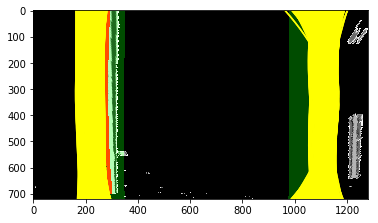

In [31]:
# Set inputs and outputs
input_video = VideoFileClip("project_video.mp4")
output_video_name = 'project_video_output.mp4'

lanes_detector = LanesDetector()
process_img  = lanes_detector.process_img

# Process the input video
output_video = input_video.fl_image(process_img)
%time output_video.write_videofile(output_video_name, audio=False)


In [32]:
# SHOW THE VIDEO
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name))